# 42186 Model-based machine learning
- Matteo Piccagnoni s232713
- Gabriel Lanaro s233541
- Manuel Lovo s243123

# Topic-aware SPAM message classification in Bayesian setup

## 1. Introduction


Spam messages are annoying, and sometimes dangerous. Classifying them correctly is important, but we often ignore one key aspect: how confident are we in the predictions? 

In this project, we take a more thoughtful approach to spam detection by combining two powerful tools: **topic modeling** and **Bayesian inference**. 

First, we use **Latent Dirichlet Allocation (LDA)** to discover the hidden topics inside SMS messages, this gives us a better understanding of what the messages are about. 
Then, instead of using a standard classifier, we go full **Bayesian** with a **logistic regression model** that doesn’t just make a prediction, it tells us how uncertain that prediction is. 

Everything is built using Pyro, a probabilistic programming library, which makes it easy to define the model and run inference using both SVI and MCMC. 

This notebook walks through the whole process step-by-step: from data cleaning to topic discovery to classification and uncertainty analysis. By the end, we’ll not only have a working spam filter: we will have one that knows when it’s unsure.

In [1]:
# penso di aver copiarto tutti import di cui abbiamo bisogno (need to double check)

# ─────────────────────────────────────────────────────────────
# General-purpose utilities
# ─────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
from functools import partial
from tqdm.auto import tqdm

# ─────────────────────────────────────────────────────────────
# NLP preprocessing
# ─────────────────────────────────────────────────────────────
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# ─────────────────────────────────────────────────────────────
# Visualization
# ─────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ─────────────────────────────────────────────────────────────
# Pyro probabilistic programming
# ─────────────────────────────────────────────────────────────
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from pyro.infer.autoguide import AutoNormal, AutoDelta

# ─────────────────────────────────────────────────────────────
# Scikit-learn tools
# ─────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# ─────────────────────────────────────────────────────────────
# Serialization
# ─────────────────────────────────────────────────────────────
import pickle
import joblib
import json

## 2. Dataset and Preprocessing

### 2.1 Dataset

In this project, the **SMS Spam Collection Dataset** has been used. It is a publicly available corpus hosted by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection) which contains 5,574 English SMS messages, each labeled as either "ham" (legitimate) or "spam" (unwanted/unsolicited).

The messages were collected from a variety of sources:
Legitimate (ham) messages were gathered from public forums, SMS chat services, and volunteer contributors.
Spam messages were obtained from known spam databases and online archives of promotional SMS campaigns.

Each row in the dataset consists of two fields:
label: A string indicating whether the message is "ham" or "spam".
message: The actual content of the SMS text, written in natural language (English).

A few example rows:

| label | message |
|-------|---------|
| ham   | Are you coming to the party later? |
| spam  | You’ve won a £1000 cash prize! Text WIN to 80086 to claim now. |


The dataset is realistic and includes a broad range of message types, from casual conversations full of slang and abbreviations to marketing promos and scams that mimic legitimate offers. This makes it ideal for studying both semantic patterns (via topic modeling) and predictive classification (spam vs. ham). The class distribution is slightly imbalanced, with around 13% spam and 87% ham, which reflects real-world conditions.

Overall, this dataset offers a compact but rich playground for experimenting with natural language processing, especially when modeling uncertainty and interpretability, as we do in this Bayesian setup.

In [ ]:
df_sms = pd.read_csv(
    "SMSSpamCollection", sep="\t", header=None, names=["label", "message"]
)
df_sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df = df_sms.copy()

We begin by inspecting the shape and class distribution of the SMS Spam Collection dataset.

In [ ]:
print(f"Dataset shape: {df_sms.shape}")
print("\nClass distribution:")
print(df_sms["label"].value_counts())

Dataset shape: (5572, 2)

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


It contains 5,572 rows and 2 columns, one for the label and one for the message text. Looking at the class distribution, we see that the majority of messages are labeled as "ham" (non-spam), with 4,825 examples, while only 747 are labeled as "spam". This imbalance is typical in real-world spam detection problems and will influence how we evaluate our model's performance later.

Before visualizing the data, we check whether the label column is stored as numeric or as strings. This lets us adapt the formatting for plots and statistical summaries. If the labels are already numeric (e.g., 0 and 1), we assume 0 corresponds to "ham" and 1 to "spam", and use that for calculating the spam rate and preparing plots. If the labels are still strings, we map them to binary values temporarily for computing the spam percentage but keep the original strings for use as plot labels.

**magari possiamo aggregare questo con cella precedente**

In [ ]:
if df_sms["label"].dtype in ["int64", "int32", "int", "float", "float64", "float32"]:
    # If numeric, assume 0=ham, 1=spam for visualization purposes
    print(f"\nSpam percentage: {df_sms['label'].mean() * 100:.2f}%")


    # For plotting, create a temporary string version

    plot_df = df_sms.copy()

    plot_df["label_str"] = plot_df["label"].map({0: "ham", 1: "spam"})


    # Set hue column for plots

    hue_col = "label_str"
else:

    # If already string, compute binary representation for some calculations

    binary_labels = df_sms["label"].map({"ham": 0, "spam": 1})

    print(f"\nSpam percentage: {binary_labels.mean() * 100:.2f}%")


    # Use original label column for plots

    plot_df = df_sms

    hue_col = "label"


Spam percentage: 13.41%


We find that around 13.4% of the messages are spam, reinforcing the class imbalance we saw earlier.

### 2.2 Exploratory Visualization

This part of the notebook explores the basic structure of the SMS messages by analyzing their length and word count. First, we compute two simple metrics for each message: the total number of characters and the number of words.


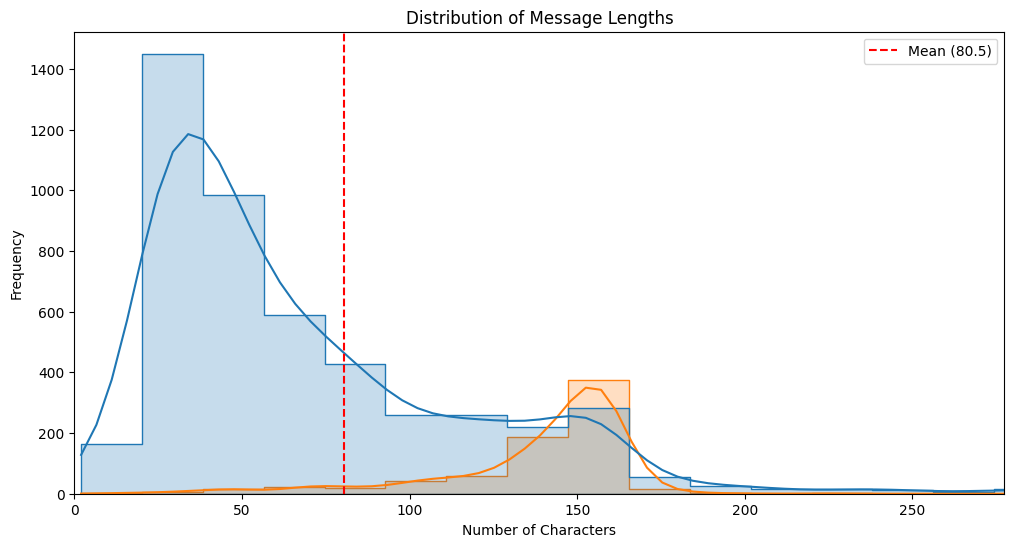

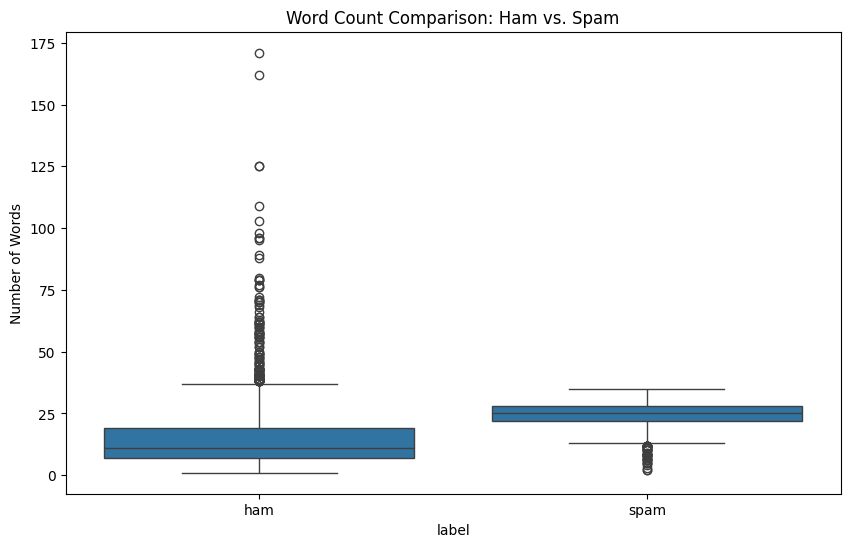

In [ ]:
message_lengths = plot_df["message"].apply(len)
word_counts = plot_df["message"].apply(lambda x: len(str(x).split()))

# Add temporary columns for visualization
plot_df["message_length"] = message_lengths
plot_df["word_count"] = word_counts

# Message length histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=plot_df, x="message_length", hue=hue_col, bins=50, kde=True, element="step"
)
plt.title("Distribution of Message Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.axvline(
    message_lengths.mean(),
    color="r",
    linestyle="--",
    label=f"Mean ({message_lengths.mean():.1f})",
)
plt.legend()
plt.xlim(0, message_lengths.quantile(0.99))  # Limit x-axis to exclude extreme outliers
plt.show()

# Words count boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=hue_col, y="word_count", data=plot_df)
plt.title("Word Count Comparison: Ham vs. Spam")
plt.ylabel("Number of Words")
plt.show()

We created an histogram showing the distribution of message lengths, separated by class. Most messages cluster around a certain range, but spam messages tend to be slightly longer on average, a red dashed line marks the overall mean. To avoid distortion from extreme outliers, the x-axis is limited to the 99th percentile.

Finally, we compare the number of words in spam vs. ham messages using a boxplot. This offers a clear view of typical word counts and highlights any differences in message usage of words between the two classes.

### 2.3 Preprocessing

Before we can use the text messages in our models, we need to clean and prepare them. Raw SMS messages are often messy including typos, slang, special characters, and unnecessary words that can confuse a model. 
In this section, we’ll go through standard preprocessing steps like **lowercasing**, **removing stopwords**, **tokenizing**, and **stemming**. These transformations help reduce noise and bring the text into a more consistent format, which is especially important for tasks like topic modeling and classification. 

We’ll explain each step as we apply it in the code.

The following setup downloads the list of common English stopwords (like "the", "is", "and") from the NLTK library and initializes the stopword set and a Porter stemmer. These components will be used later to remove common words that carry little semantic meaning and to reduce words to their base form, respectively.

In [91]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lovomanuel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The following function performs standard text preprocessing to prepare SMS messages for further analysis. It includes lowercasing, removal of URLs, numbers, and punctuation, followed by tokenization, stopword removal, and stemming. 
The result is a list of cleaned and normalized tokens for each message.

In [92]:
# Text Cleaning Function
def clean_message(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", "", text)  # Remove URLs
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.translate(
        str.maketrans("", "", string.punctuation)
    )  # Remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

The cleaned tokenization function is applied to each message in the dataset using the apply method. A new column, "tokens", is created to store the resulting list of preprocessed tokens for each SMS message.

In [93]:
df["tokens"] = df["message"].apply(clean_message)
df.head()

,label,message,tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


The code offers a closer look at the most common words used in spam and ham messages after preprocessing.
We first collect all tokenized words for each class, flatten the lists into single sequences of words, and then count the frequency of each word. After identifying the top 20 most frequent words for ham and spam separately, we visualize them using two horizontal bar plots.

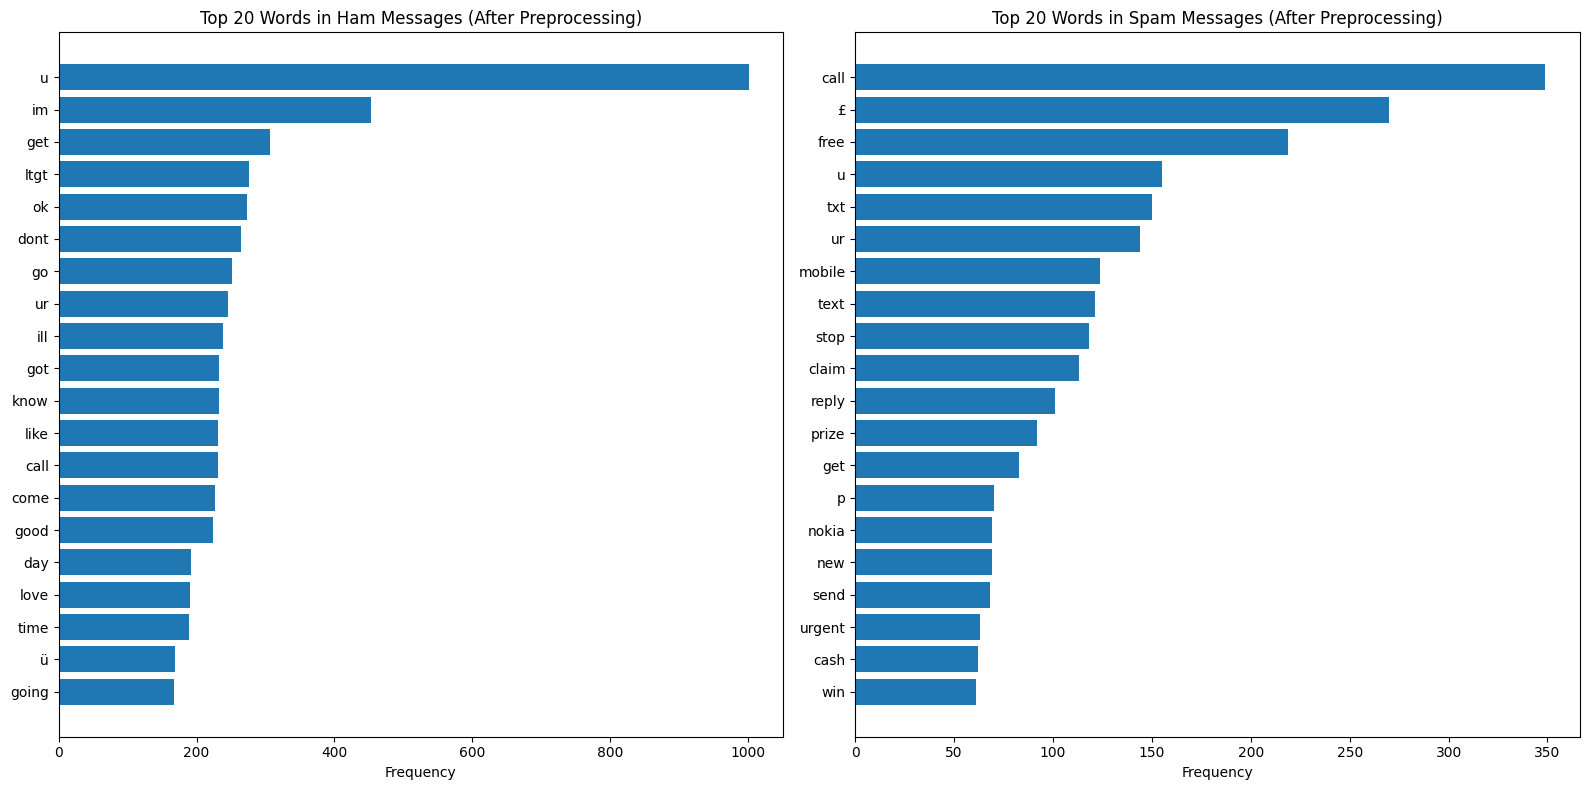

In [ ]:
if hue_col == "label":
    ham_tokens = [
        tokens for i, tokens in enumerate(df["tokens"]) if df["label"].iloc[i] == "ham"
    ]
    spam_tokens = [
        tokens for i, tokens in enumerate(df["tokens"]) if df["label"].iloc[i] == "spam"
    ]
else:
    ham_tokens = [
        tokens
        for i, tokens in enumerate(df["tokens"])
        if df["label_str"].iloc[i] == "ham"
    ]
    spam_tokens = [
        tokens
        for i, tokens in enumerate(df["tokens"])
        if df["label_str"].iloc[i] == "spam"
    ]

# Flatten the lists of tokens
ham_words = [word for sublist in ham_tokens for word in sublist]
spam_words = [word for sublist in spam_tokens for word in sublist]

# Count word frequencies
ham_word_counts = Counter(ham_words)
spam_word_counts = Counter(spam_words)

# Get top 20 words
top_ham_words = dict(ham_word_counts.most_common(20))
top_spam_words = dict(spam_word_counts.most_common(20))

# Plot top words for each class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Ham words
ax1.barh(
    list(reversed(list(top_ham_words.keys()))),
    list(reversed(list(top_ham_words.values()))),
)
ax1.set_title("Top 20 Words in Ham Messages (After Preprocessing)")
ax1.set_xlabel("Frequency")

# Spam words
ax2.barh(
    list(reversed(list(top_spam_words.keys()))),
    list(reversed(list(top_spam_words.values()))),
)
ax2.set_title("Top 20 Words in Spam Messages (After Preprocessing)")
ax2.set_xlabel("Frequency")

plt.tight_layout()
plt.show()

These visualizations help highlight patterns and distinctive vocabulary. For example, spam messages shows a higher occurrence of promotional or financial terms, while ham messages often include more casual or conversational language. These patterns support the idea that topic modeling can be informative for the downstream classification task.

Following the bar plots showing the top 20 most frequent words, word clouds are used to give a more intuitive, visual impression of the vocabulary used in ham and spam messages.

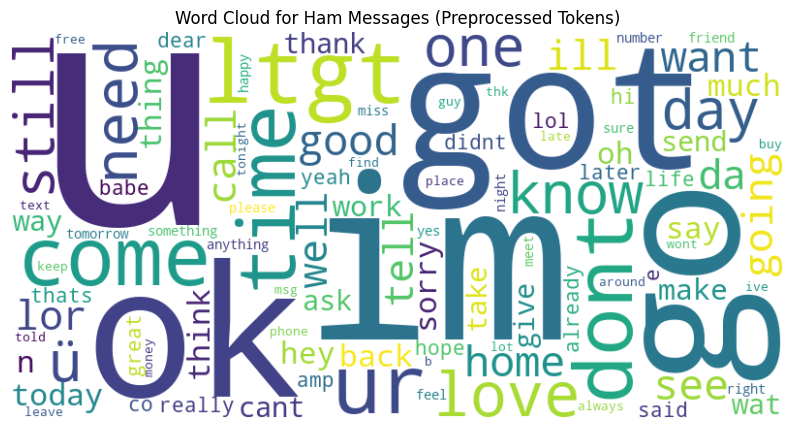

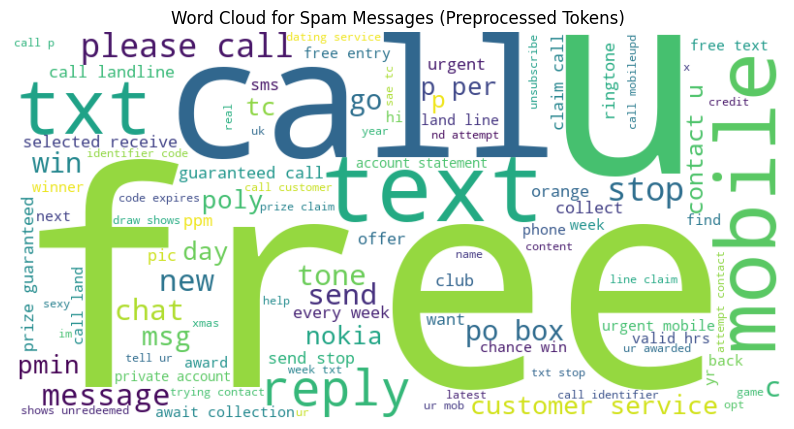

In [ ]:
# Word clouds for processed tokens
plt.figure(figsize=(10, 8))
ham_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100,
    contour_width=3,
    contour_color="steelblue",
).generate(" ".join(ham_words))
plt.imshow(ham_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Ham Messages (Preprocessed Tokens)")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 8))
spam_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100,
    contour_width=3,
    contour_color="firebrick",
).generate(" ".join(spam_words))
plt.imshow(spam_wordcloud, interpolation="bilinear")
plt.title("Word Cloud for Spam Messages (Preprocessed Tokens)")
plt.axis("off")
plt.show()

In [ ]:
stemmer = PorterStemmer()



def stem_tokens(tokens):

    return [stemmer.stem(token) for token in tokens]




df["stemmed_tokens"] = df["tokens"].apply(stem_tokens)

df.head()

,label,message,tokens,stemmed_tokens
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entri, wkli, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, goe, usf, live, around, tho..."


Above it is provides a quick preview of the structure and content of the DataFrame. At this stage, the output includes the raw message text, and the newly added tokens column, which contains the list of cleaned and preprocessed words extracted from each message. From the raw message to the tokenized version, the following elements were removed: URLs, numbers, punctuation, common stopwords, and words were reduced to their stemmed forms.

>Please notice that in the `stemmed_tokens` column, some words appear in their stemmed form (for example, "crazy" becomes "crazi"). This is a result of the Porter stemming algorithm, which reduces words to their morphological root to group similar terms together. While the resulting stems are not always real words, they help the model treat related terms (e.g., "crazy", "craziness") as the same feature.
It is also worth noting that abbreviations and slang (e.g., "u", "ur", "msg") were intentionally left unchanged. Although these do not follow standard grammar, they often carry important contextual or signals in SMS communication. Removing or expanding them could potentially obscure patterns that distinguish spam from ham in this domain.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import joblib
import json

print(f"Loaded data with {df.shape[0]} messages")
print(f"Columns: {df.columns.tolist()}")
print(f"Sample data:\n{df.head()}")

# Join tokens back to strings (for CountVectorizer)
print("Processing stemmed_tokens...")
texts_str = df["stemmed_tokens"].apply(
    lambda tokens: " ".join(tokens) if isinstance(tokens, (list, str)) else str(tokens)
)

print("Sample processed texts:")
print(texts_str.head())

# Create bag-of-words matrix
print("\nCreating document-term matrix...")
vectorizer = CountVectorizer(min_df=5, max_df=0.95, max_features=5000)
X = vectorizer.fit_transform(texts_str)
X_array = X.toarray()
print(f"Document-term matrix shape: {X_array.shape}")

# Convert labels to binary (0=ham, 1=spam)
print("\nProcessing labels...")
y_array = df["label"].map({"ham": 0, "spam": 1}).values
print(f"Label distribution: {y_array.mean():.4f} (proportion of spam)")

# Get vocabulary
vocab = vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(vocab)}")
print(f"Sample vocabulary terms: {list(vocab)[:10]}")

# Check for empty documents
doc_word_counts = X_array.sum(axis=1)
empty_docs = doc_word_counts == 0
if empty_docs.sum() > 0:
    print(f"\nWARNING: Found {empty_docs.sum()} empty documents")
    print("These documents will be handled by the LDA model")

# Save the data in npz format (without vocabulary to avoid pickle issues)
print("\nSaving data to sms_data.npz...")
np.savez_compressed(
    "sms_data.npz",
    X=X_array.astype(np.float32),  # Document-term matrix
    y=y_array.astype(np.int8),
)  # Binary labels (0=ham, 1=spam)

# Save vocabulary as a JSON file (most reliable for text data)
print("Saving vocabulary to sms_vocab.json...")
with open("sms_vocab.json", "w", encoding="utf-8") as f:
    json.dump(vocab.tolist(), f)

# Also save the vectorizer for processing new texts
print("Saving vectorizer to sms_vectorizer.joblib...")
joblib.dump(vectorizer, "sms_vectorizer.joblib")

print("\nDone! Files saved:")
print("- sms_data.npz: Contains document-term matrix and labels")
print("- sms_vocab.json: Contains vocabulary in JSON format")
print("- sms_vectorizer.joblib: Contains the fitted CountVectorizer")

Loaded data with 5572 messages
Columns: ['label', 'message', 'tokens', 'stemmed_tokens']
Sample data:
  label                                            message  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                              tokens  \
0  [go, jurong, point, crazy, available, bugis, n...   
1                     [ok, lar, joking, wif, u, oni]   
2  [free, entry, wkly, comp, win, fa, cup, final,...   
3      [u, dun, say, early, hor, u, c, already, say]   
4  [nah, dont, think, goes, usf, lives, around, t...   

                                      stemmed_tokens  
0  [go, jurong, point, crazi, avail, bugi, n, gre...  
1                       [ok, lar, joke, wif, u, oni]  
2  [free, entri, wkli, 

In this step, the list of tokens for each message is joined back into a single string to prepare the input for CountVectorizer, which requires text input in string format. The CountVectorizer transforms the preprocessed messages into a bag-of-words (BoW) matrix, where each row represents a message and each column corresponds to a word in the vocabulary, with entries indicating the word count per message.
This BoW representation is a standard format for text modeling and is especially useful for Latent Dirichlet Allocation (LDA), which operates on document-word frequency data. The resulting matrix is converted into a PyTorch tensor to be compatible with Pyro, which is used for building and training the probabilistic topic model.


MUST BE EXPLAINED ALSO THAT WE REMOVE VERY INFREQUENT WORDS FROM THE VECTORIZER ETC

## 3. Modeling

In this section, we implement the core of our Bayesian spam classification pipeline, which combines topic modeling with Bayesian logistic regression. The main goal is to model the latent topics in SMS messages using Latent Dirichlet Allocation (LDA) and then classify them as spam or ham with a Bayesian approach that accounts for uncertainty in predictions.

Unlike a traditional two-stage approach where LDA and classification are disconnected, we adopt a unified class-based design (`LDA_BLR`) that integrates both components and automates a full grid search over their hyperparameters.

### 3.1 Model pipeline overview

Our modeling pipeline consists of:

1. **LDA (Latent Dirichlet Allocation)**:
   - A generative probabilistic model that infers latent topics in a collection of documents.
   - Each message is represented as a distribution over `K` topics.
   - We fit LDA via MAP inference using `AutoDelta` in Pyro, which gives us deterministic estimates of topic-word and document-topic distributions.

2. **Bayesian Logistic Regression (BLR)**:
   - A probabilistic classifier using a Bernoulli likelihood.
   - We place Gaussian priors over weights and bias and perform inference using:
     - **SVI** (Stochastic Variational Inference): fast, approximate.
     - **MCMC** (via NUTS): slower, but samples from the true posterior.
   - The model predicts the probability of a message being spam given its topic representation.

3. **Grid Search**:
   - We explore combinations of LDA and BLR hyperparameters:
     - Number of topics (`K`)
     - Dirichlet priors for LDA (`α`, `β`)
     - Prior scale (`σ`) for BLR
     - Inference method (`svi`, `mcmc`)
   - We evaluate on validation accuracy and AUC, and retain the best model to assess performance on the test set.

This combined setup allows us to leverage the interpretability of topics and the uncertainty quantification of Bayesian models, producing not just predictions, but also insights and calibrated confidence levels.


### 3.2 Model definition

This section defines a modular class, `LDA_BLR`, which implements our full modeling pipeline:
- **Topic modeling via LDA** (Latent Dirichlet Allocation)
- **Spam classification via Bayesian Logistic Regression (BLR)**
- **Hyperparameter tuning** through grid search
- **Posterior inference** using either SVI or MCMC

The goal is to encapsulate all modeling logic into a reusable, readable Pyro-based implementation.


The main components are:
- **`prepare_data()`**: Prepares input tensors and splits into train/val/test.
- **`_train_lda()`** and **`_infer_doc_topics()`**: Trains and evaluates LDA using MAP estimation with `AutoDelta`.
- **`_make_blr_model()`**, **`_train_blr_svi()`**, **`_train_blr_mcmc()`**: Defines and trains the Bayesian logistic regression using SVI or MCMC.
- **`train_model()`**: Runs a full grid search over LDA and BLR hyperparameters.
- **`predict()`**: Makes test predictions using the best model.
- **`plot_topics()`**: Visualizes top-N words per topic.

Once this class is defined, we will use it in the next section to perform model selection and evaluate performance.

**aggiungere piu spiegazioone perche codice molto lungo** 


In [18]:
pyro.set_rng_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] running on {device}")


# ────────────────────────────────────────────────────────────────────────
#  Main class
# ────────────────────────────────────────────────────────────────────────
class LDA_BLR:
    """
    • LDA (fixed-length Multinomial, MAP via AutoDelta)
    • BLR with Normal(0, σ) prior, trained by SVI **or** NUTS
    """

    def __init__(self):
        self.lda_trained = False
        self.blr_trained = False

    # -------------------------------------------------------------------
    #  data split
    # -------------------------------------------------------------------
    def prepare_data(self, X, y, train_size=0.9, val_ratio=0.5):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(
                X.toarray() if hasattr(X, "toarray") else X, dtype=torch.float32
            ).to(device)
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.float32).to(device)

        X_trv, X_te, y_trv, y_te = train_test_split(
            X, y, train_size=train_size, stratify=y, random_state=42
        )
        X_tr, X_va, y_tr, y_va = train_test_split(
            X_trv, y_trv, test_size=val_ratio, stratify=y_trv, random_state=42
        )

        self.X_train, self.X_val, self.X_test = X_tr, X_va, X_te
        self.y_train, self.y_val, self.y_test = y_tr, y_va, y_te
        self.num_docs, self.vocab_size = X.shape

        print(
            f"[INFO] docs {self.num_docs} | vocab {self.vocab_size} | "
            f"train {X_tr.shape[0]}  val {X_va.shape[0]}  test {X_te.shape[0]}"
        )

    # -------------------------------------------------------------------
    #  top-level grid search
    # -------------------------------------------------------------------
    def train_model(
        self,
        K_values,
        alpha_values,
        beta_values,
        prior_scale_values,
        blr_methods=("svi", "mcmc"),
        lda_iters=300,
        blr_svi_iters=400,
        blr_mcmc_samples=800,
        blr_mcmc_warmup=200,
        total_count=100,
    ):
        """
        Searches every combo of
          K × α × β × σ × {svi|mcmc}
        Selects best validation accuracy (AUC tie-break).
        """
        results, best_acc, best_auc = [], -np.inf, -np.inf

        grid = [
            (K, a, b, ps, m)
            for K in K_values
            for a in alpha_values
            for b in beta_values
            for ps in prior_scale_values
            for m in blr_methods
        ]

        for idx, (K, alpha, beta, ps, method) in enumerate(grid, 1):
            print(
                f"\n[{idx}/{len(grid)}]  "
                f"K={K} α={alpha} β={beta} | σ={ps}  BLR={method.upper()}"
            )

            try:
                lda_post = self._train_lda(K, alpha, beta, lda_iters, total_count)
                Z_tr = lda_post["doc_topics"].detach()
                topic_words = lda_post["topic_words"].detach()
                Z_va = self._infer_doc_topics(
                    self.X_val, K, alpha, topic_words, total_count
                )

                if method == "svi":
                    blr_obj = self._train_blr_svi(Z_tr, self.y_train, ps, blr_svi_iters)
                else:  # mcmc
                    blr_obj = self._train_blr_mcmc(
                        Z_tr, self.y_train, ps, blr_mcmc_samples, blr_mcmc_warmup
                    )

                val_acc, val_auc = self._eval_blr(Z_va, self.y_val, blr_obj, method, ps)
                print(f"    val ACC={val_acc:.4f}  AUC={val_auc:.4f}")

                results.append(
                    dict(
                        K=K,
                        alpha=alpha,
                        beta=beta,
                        prior_scale=ps,
                        method=method,
                        val_accuracy=val_acc,
                        val_auc=val_auc,
                    )
                )

                if (val_acc > best_acc) or (val_acc == best_acc and val_auc > best_auc):
                    best_acc, best_auc = val_acc, val_auc
                    (
                        self.best_K,
                        self.best_alpha,
                        self.best_beta,
                        self.best_prior_scale,
                        self.best_method,
                    ) = (K, alpha, beta, ps, method)
                    self.best_topic_words, self.best_blr_obj = topic_words, blr_obj

            except Exception as exc:
                print("    ⚠", type(exc).__name__, "-", exc)
                continue

        # test set ---------------------------------------------------------
        if hasattr(self, "best_K"):
            self.lda_trained = self.blr_trained = True
            Z_te = self._infer_doc_topics(
                self.X_test,
                self.best_K,
                self.best_alpha,
                self.best_topic_words,
                total_count,
            )
            te_acc, te_auc = self._eval_blr(
                Z_te,
                self.y_test,
                self.best_blr_obj,
                self.best_method,
                self.best_prior_scale,
            )
            print(
                f"\n[✓] best  K={self.best_K} α={self.best_alpha} β={self.best_beta} "
                f"| σ={self.best_prior_scale}  BLR={self.best_method.upper()}   "
                f"test ACC={te_acc:.4f} AUC={te_auc:.4f}"
            )

        return pd.DataFrame(results)

    # -------------------------------------------------------------------
    #  LDA – MAP with AutoDelta
    # -------------------------------------------------------------------
    def _normalise_counts(self, data, total_count):
        row_sum = data.sum(1, keepdim=True)
        uniform = torch.full(
            (1, data.shape[1]), 1.0 / data.shape[1], device=data.device
        )
        probs = torch.where(row_sum == 0, uniform, data / row_sum)
        return dist.Multinomial(total_count, probs=probs).sample().to(device)

    def _train_lda(self, K, alpha, beta, iters, total_count):
        pyro.clear_param_store()
        counts = self._normalise_counts(self.X_train, total_count)

        def model(data):
            with pyro.plate("topics", K):
                topic_words = pyro.sample(
                    "topic_words",
                    dist.Dirichlet(beta * torch.ones(self.vocab_size, device=device)),
                )
            with pyro.plate("docs", data.shape[0]):
                doc_topics = pyro.sample(
                    "doc_topics", dist.Dirichlet(alpha * torch.ones(K, device=device))
                )
                word_probs = doc_topics @ topic_words
                word_probs = word_probs / word_probs.sum(-1, keepdim=True)
                pyro.sample(
                    "doc_words",
                    dist.Multinomial(total_count, probs=word_probs),
                    obs=data,
                )

        guide = AutoDelta(model)
        svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
        for _ in tqdm(range(iters), desc=f"LDA K={K}"):
            svi.step(counts)

        post = guide()
        return {
            "topic_words": post["topic_words"].detach(),
            "doc_topics": post["doc_topics"].detach(),
        }

    def _infer_doc_topics(self, docs, K, alpha, topic_words, total_count):
        pyro.clear_param_store()
        counts = self._normalise_counts(docs, total_count)

        def model(data):
            with pyro.plate("docs", data.shape[0]):
                doc_topics = pyro.sample(
                    "doc_topics", dist.Dirichlet(alpha * torch.ones(K, device=device))
                )
                word_probs = doc_topics @ topic_words
                word_probs = word_probs / word_probs.sum(-1, keepdim=True)
                pyro.sample(
                    "doc_words",
                    dist.Multinomial(total_count, probs=word_probs),
                    obs=data,
                )
            return doc_topics

        guide = AutoDelta(model)
        svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
        for _ in range(100):
            svi.step(counts)
        return guide()["doc_topics"].detach()

    # -------------------------------------------------------------------
    #  BLR helpers
    # -------------------------------------------------------------------
    @staticmethod
    def _make_blr_model(prior_scale):
        def blr_model(X, y=None):
            D = X.shape[1]
            weights = pyro.sample(
                "weights",
                dist.Normal(
                    torch.zeros(D, device=device),
                    prior_scale * torch.ones(D, device=device),
                ).to_event(1),
            )
            bias = pyro.sample("bias", dist.Normal(0.0, prior_scale))
            logits = X @ weights + bias
            with pyro.plate("obs", X.shape[0]):
                pyro.sample("y", dist.Bernoulli(logits=logits), obs=y)

        return blr_model

    # --- SVI -------------------------------------------------------------
    def _train_blr_svi(self, X, y, prior_scale, iters):
        pyro.clear_param_store()
        blk_model = poutine.block(self._make_blr_model(prior_scale), hide=["y"])
        guide = AutoNormal(blk_model)
        svi = SVI(blk_model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
        for _ in tqdm(range(iters), desc="BLR SVI"):
            svi.step(X, y)
        return guide

    # --- MCMC ------------------------------------------------------------
    def _train_blr_mcmc(self, X, y, prior_scale, num_samples, warmup):
        pyro.clear_param_store()
        model = self._make_blr_model(prior_scale)
        nuts = NUTS(model)
        mcmc = MCMC(
            nuts, num_samples=num_samples, warmup_steps=warmup, disable_progbar=False
        )
        mcmc.run(X, y)
        return mcmc

    # --- evaluation ------------------------------------------------------
    def _eval_blr(self, X, y, blr_obj, method, prior_scale, samples=400):
        if method == "svi":
            predictive = Predictive(
                self._make_blr_model(prior_scale), guide=blr_obj, num_samples=samples
            )
            probs = predictive(X)["y"].mean(0).cpu().numpy()
        else:  # mcmc
            samps = blr_obj.get_samples(group_by_chain=False)
            logits = X @ samps["weights"].transpose(0, 1) + samps["bias"]
            probs = torch.sigmoid(logits).mean(1).cpu().numpy()

        preds = (probs > 0.5).astype(int)
        return accuracy_score(y.cpu(), preds), roc_auc_score(y.cpu(), probs)

    # -------------------------------------------------------------------
    #  public predict
    # -------------------------------------------------------------------
    def predict(self, X, samples=400, total_count=100):
        if not (self.lda_trained and self.blr_trained):
            raise RuntimeError("fit the model first")

        if not isinstance(X, torch.Tensor):
            X = torch.tensor(
                X.toarray() if hasattr(X, "toarray") else X, dtype=torch.float32
            ).to(device)

        Z = self._infer_doc_topics(
            X, self.best_K, self.best_alpha, self.best_topic_words, total_count
        )

        if self.best_method == "svi":
            predictive = Predictive(
                self._make_blr_model(self.best_prior_scale),
                guide=self.best_blr_obj,
                num_samples=samples,
            )
            probs = predictive(Z)["y"].mean(0)
        else:
            samps = self.best_blr_obj.get_samples(group_by_chain=False)
            logits = Z @ samps["weights"].transpose(0, 1) + samps["bias"]
            probs = torch.sigmoid(logits).mean(1)

        return probs.cpu().numpy(), (probs > 0.5).int().cpu().numpy()

    # -------------------------------------------------------------------
    #  topic visualisation
    # -------------------------------------------------------------------
    def plot_topics(self, vocab, top_n=10):
        if not self.lda_trained:
            raise RuntimeError("train LDA first")

        K = self.best_K
        tw = self.best_topic_words.cpu().numpy()
        ncol, nrow = min(3, K), int(np.ceil(K / min(3, K)))
        fig, axs = plt.subplots(nrow, ncol, figsize=(5 * ncol, 2.5 * nrow))
        axs = np.array(axs).reshape(-1)
        for k in range(K):
            idx = np.argsort(-tw[k])[:top_n]
            axs[k].barh(range(top_n), tw[k][idx][::-1])
            axs[k].set_yticks(range(top_n))
            axs[k].set_yticklabels([vocab[i] for i in idx][::-1])
            axs[k].invert_yaxis()
            axs[k].set_title(f"Topic {k}")
        for ax in axs[K:]:
            ax.axis("off")
        plt.tight_layout()
        plt.show()

[INFO] running on cpu


### 3.4 Training and Evaluation

Now we run the full modeling pipeline using the `LDA_BLR` class.

The following steps are performed:
1. **Text vectorization**: Convert preprocessed messages into a Bag-of-Words (BoW) representation.
2. **Label encoding**: Map "ham" to 0 and "spam" to 1.
3. **Model training**: Run grid search over LDA and BLR hyperparameters.
4. **Validation performance**: Evaluate each model on the validation set using accuracy and AUC.
5. **Best model selection**: Identify and test the best model on held-out test data.

This function writes the full search results to a `.csv` and reports the best configuration.


In [ ]:
# ────────────────────────────────────────────────────────────────────────
#  Minimal usage example
# ────────────────────────────────────────────────────────────────────────
def main():
    """
    Assumes a dataframe `df` with
        stemmed_tokens : list[str]
        label          : "ham" | "spam"
    """
    global df  # provided externally

    texts = df["stemmed_tokens"].apply(" ".join)
    vec = CountVectorizer(min_df=5, max_df=0.95, max_features=5000)
    X = vec.fit_transform(texts)
    y = df["label"].map({"ham": 0, "spam": 1}).values

    lda_blr = LDA_BLR()
    lda_blr.prepare_data(X, y)

    results = lda_blr.train_model(
        K_values=[5, 8, 10, 15, 20, 25, 30, 35],
        alpha_values=[0.1, 0.5, 1.0],
        beta_values=[0.01, 0.1, 0.5, 1.0],
        prior_scale_values=[0.1, 0.5, 1.0, 2.0],
        blr_methods=("svi", "mcmc"),
        lda_iters=1000,
        blr_svi_iters=1000,
        blr_mcmc_samples=800,
        blr_mcmc_warmup=200,
        total_count=100,
    )

    results.to_csv("hyperparameter_results.csv", index=False)
    print(
        "[INFO] finished - best row:\n",
        results.sort_values("val_accuracy", ascending=False).head(1),
    )


if __name__ == "__main__":
    main()

### 3.5 Results

## 4. Conclusions ??

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Step-by-Step LDA-BLR Analysis
Starting with finding best models for SVI and MCMC
"""

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION - UPDATE THIS PATH
# =============================================================================

# Path to your LDA_BLR_Models folder (update this!)
BASE_FOLDER = "run_20250521_160358"  # Change this to your actual path

# =============================================================================
# STEP 1: LOAD ALL RESULTS
# =============================================================================

def load_all_results():
    """Load results from all experiment runs"""
    base_path = Path(BASE_FOLDER)
    
    if not base_path.exists():
        print(f"❌ ERROR: Folder not found: {BASE_FOLDER}")
        print("Please update BASE_FOLDER variable")
        return None
    
    # Find all run folders
    run_folders = [f for f in base_path.iterdir() 
                  if f.is_dir() and f.name.startswith('run_')]
    
    print(f"📁 Found {len(run_folders)} experiment runs")
    
    if len(run_folders) == 0:
        print("❌ No run folders found!")
        return None
    
    all_results = []
    
    for run_folder in sorted(run_folders):
        print(f"  📂 Checking {run_folder.name}...")
        
        # Try final results first
        results_file = run_folder / "final_results.csv"
        if results_file.exists():
            df = pd.read_csv(results_file)
            df['run_id'] = run_folder.name
            df['run_timestamp'] = run_folder.name.replace('run_', '')
            all_results.append(df)
            print(f"    ✅ Loaded {len(df)} results from final_results.csv")
            continue
            
        # Try grid search results
        results_file = run_folder / "grid_search_results.csv"
        if results_file.exists():
            df = pd.read_csv(results_file)
            df['run_id'] = run_folder.name
            df['run_timestamp'] = run_folder.name.replace('run_', '')
            all_results.append(df)
            print(f"    ✅ Loaded {len(df)} results from grid_search_results.csv")
        else:
            print(f"    ⚠️  No results file found")
    
    if all_results:
        combined_df = pd.concat(all_results, ignore_index=True)
        print(f"\n✅ Total results loaded: {len(combined_df)}")
        print(f"📊 Columns available: {list(combined_df.columns)}")
        return combined_df
    else:
        print("❌ No results could be loaded!")
        return None

# =============================================================================
# STEP 2: FIND BEST MODELS FOR SVI AND MCMC
# =============================================================================

def get_best_models_by_method(results_df):
    """
    Find the best performing model for each method (SVI and MCMC)
    
    Args:
        results_df: DataFrame with all experimental results
        
    Returns:
        dict: Best models for each method
    """
    
    if results_df is None:
        print("❌ No results data provided")
        return None
    
    if 'method' not in results_df.columns:
        print("❌ 'method' column not found in results")
        print(f"Available columns: {list(results_df.columns)}")
        return None
    
    print("\n" + "="*50)
    print("🏆 FINDING BEST MODELS BY METHOD")
    print("="*50)
    
    # Check what methods we have
    available_methods = results_df['method'].unique()
    print(f"📋 Available methods: {available_methods}")
    
    best_models = {}
    
    # Find best SVI model
    if 'svi' in available_methods:
        svi_results = results_df[results_df['method'] == 'svi'].copy()
        
        # Sort by validation accuracy (primary) and AUC (secondary)
        svi_results = svi_results.sort_values(['val_accuracy', 'val_auc'], ascending=False)
        best_svi = svi_results.iloc[0]
        
        best_models['svi'] = {
            'model_data': best_svi,
            'performance': {
                'val_accuracy': best_svi['val_accuracy'],
                'val_auc': best_svi['val_auc'],
                'test_accuracy': best_svi.get('test_accuracy', 'N/A'),
                'test_auc': best_svi.get('test_auc', 'N/A')
            },
            'hyperparameters': {
                'K': best_svi['K'],
                'alpha': best_svi['alpha'], 
                'beta': best_svi['beta'],
                'prior_scale': best_svi['prior_scale']
            },
            'total_svi_models': len(svi_results)
        }
        
        print(f"\n🥇 BEST SVI MODEL:")
        print(f"   📈 Validation Accuracy: {best_svi['val_accuracy']:.4f}")
        print(f"   📈 Validation AUC: {best_svi['val_auc']:.4f}")
        if 'test_accuracy' in best_svi and pd.notna(best_svi['test_accuracy']):
            print(f"   🎯 Test Accuracy: {best_svi['test_accuracy']:.4f}")
            print(f"   🎯 Test AUC: {best_svi['test_auc']:.4f}")
        print(f"   ⚙️  Hyperparameters:")
        print(f"      - K (topics): {best_svi['K']}")
        print(f"      - α (doc-topic): {best_svi['alpha']}")
        print(f"      - β (topic-word): {best_svi['beta']}")
        print(f"      - Prior scale: {best_svi['prior_scale']}")
        print(f"   📊 Total SVI models tested: {len(svi_results)}")
        
    else:
        print("⚠️  No SVI results found")
    
    # Find best MCMC model
    if 'mcmc' in available_methods:
        mcmc_results = results_df[results_df['method'] == 'mcmc'].copy()
        
        # Sort by validation accuracy (primary) and AUC (secondary)
        mcmc_results = mcmc_results.sort_values(['val_accuracy', 'val_auc'], ascending=False)
        best_mcmc = mcmc_results.iloc[0]
        
        best_models['mcmc'] = {
            'model_data': best_mcmc,
            'performance': {
                'val_accuracy': best_mcmc['val_accuracy'],
                'val_auc': best_mcmc['val_auc'],
                'test_accuracy': best_mcmc.get('test_accuracy', 'N/A'),
                'test_auc': best_mcmc.get('test_auc', 'N/A')
            },
            'hyperparameters': {
                'K': best_mcmc['K'],
                'alpha': best_mcmc['alpha'],
                'beta': best_mcmc['beta'], 
                'prior_scale': best_mcmc['prior_scale']
            },
            'total_mcmc_models': len(mcmc_results)
        }
        
        print(f"\n🥇 BEST MCMC MODEL:")
        print(f"   📈 Validation Accuracy: {best_mcmc['val_accuracy']:.4f}")
        print(f"   📈 Validation AUC: {best_mcmc['val_auc']:.4f}")
        if 'test_accuracy' in best_mcmc and pd.notna(best_mcmc['test_accuracy']):
            print(f"   🎯 Test Accuracy: {best_mcmc['test_accuracy']:.4f}")
            print(f"   🎯 Test AUC: {best_mcmc['test_auc']:.4f}")
        print(f"   ⚙️  Hyperparameters:")
        print(f"      - K (topics): {best_mcmc['K']}")
        print(f"      - α (doc-topic): {best_mcmc['alpha']}")
        print(f"      - β (topic-word): {best_mcmc['beta']}")
        print(f"      - Prior scale: {best_mcmc['prior_scale']}")
        print(f"   📊 Total MCMC models tested: {len(mcmc_results)}")
        
    else:
        print("⚠️  No MCMC results found")
    
    # Compare methods if both available
    if 'svi' in best_models and 'mcmc' in best_models:
        print(f"\n🔄 METHOD COMPARISON:")
        svi_acc = best_models['svi']['performance']['val_accuracy']
        mcmc_acc = best_models['mcmc']['performance']['val_accuracy']
        
        if svi_acc > mcmc_acc:
            diff = svi_acc - mcmc_acc
            print(f"   🏆 SVI wins by {diff:.4f} accuracy points")
        elif mcmc_acc > svi_acc:
            diff = mcmc_acc - svi_acc
            print(f"   🏆 MCMC wins by {diff:.4f} accuracy points")
        else:
            print(f"   🤝 Tie in accuracy!")
            
        # Compare hyperparameters
        svi_params = best_models['svi']['hyperparameters']
        mcmc_params = best_models['mcmc']['hyperparameters']
        
        print(f"\n📋 HYPERPARAMETER COMPARISON:")
        print(f"   K:           SVI={svi_params['K']:2d}  vs  MCMC={mcmc_params['K']:2d}")
        print(f"   α:           SVI={svi_params['alpha']:4.1f}  vs  MCMC={mcmc_params['alpha']:4.1f}")
        print(f"   β:           SVI={svi_params['beta']:4.2f}  vs  MCMC={mcmc_params['beta']:4.2f}")
        print(f"   Prior scale: SVI={svi_params['prior_scale']:4.1f}  vs  MCMC={mcmc_params['prior_scale']:4.1f}")
        
        # Check if they use same LDA parameters
        same_lda = (svi_params['K'] == mcmc_params['K'] and 
                   svi_params['alpha'] == mcmc_params['alpha'] and
                   svi_params['beta'] == mcmc_params['beta'])
        
        if same_lda:
            print(f"   ✅ Both methods use same LDA parameters")
        else:
            print(f"   ❌ Methods use different LDA parameters")
    
    print(f"\n💾 Found best models for {len(best_models)} method(s)")
    
    return best_models

def display_best_models_summary(best_models):
    """Display a clean summary table of best models"""
    
    if not best_models:
        print("❌ No best models to display")
        return
        
    print("\n" + "="*80)
    print("📊 BEST MODELS SUMMARY TABLE")
    print("="*80)
    
    # Create summary dataframe
    summary_data = []
    
    for method, model_info in best_models.items():
        perf = model_info['performance']
        hyper = model_info['hyperparameters']
        
        summary_data.append({
            'Method': method.upper(),
            'Val_Accuracy': f"{perf['val_accuracy']:.4f}",
            'Val_AUC': f"{perf['val_auc']:.4f}",
            'Test_Accuracy': f"{perf['test_accuracy']:.4f}" if perf['test_accuracy'] != 'N/A' else 'N/A',
            'Test_AUC': f"{perf['test_auc']:.4f}" if perf['test_auc'] != 'N/A' else 'N/A',
            'K': hyper['K'],
            'Alpha': hyper['alpha'],
            'Beta': hyper['beta'],
            'Prior_Scale': hyper['prior_scale']
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    return summary_df

def save_best_models(best_models, output_folder="./analysis_output"):
    """Save best models information to files"""
    
    os.makedirs(output_folder, exist_ok=True)
    
    # Save as JSON
    json_data = {}
    for method, model_info in best_models.items():
        # Convert numpy types to regular Python types for JSON serialization
        json_data[method] = {
            'performance': {k: float(v) if v != 'N/A' else 'N/A' 
                          for k, v in model_info['performance'].items()},
            'hyperparameters': {k: float(v) for k, v in model_info['hyperparameters'].items()},
            'total_models_tested': model_info[f'total_{method}_models']
        }
    
    json_path = os.path.join(output_folder, "best_models.json")
    with open(json_path, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    # Save as CSV
    summary_data = []
    for method, model_info in best_models.items():
        perf = model_info['performance']
        hyper = model_info['hyperparameters']
        
        summary_data.append({
            'method': method,
            'val_accuracy': perf['val_accuracy'],
            'val_auc': perf['val_auc'],
            'test_accuracy': perf['test_accuracy'] if perf['test_accuracy'] != 'N/A' else None,
            'test_auc': perf['test_auc'] if perf['test_auc'] != 'N/A' else None,
            'K': hyper['K'],
            'alpha': hyper['alpha'],
            'beta': hyper['beta'],
            'prior_scale': hyper['prior_scale'],
            'total_models_tested': model_info[f'total_{method}_models']
        })
    
    summary_df = pd.DataFrame(summary_data)
    csv_path = os.path.join(output_folder, "best_models.csv")
    summary_df.to_csv(csv_path, index=False)
    
    print(f"\n💾 Best models saved to:")
    print(f"   📄 {json_path}")
    print(f"   📄 {csv_path}")

# =============================================================================
# MAIN EXECUTION FOR STEP 1
# =============================================================================

def run_step1_find_best_models():
    """Run step 1: Find best models for SVI and MCMC"""
    
    print("🚀 STEP 1: FINDING BEST MODELS FOR SVI AND MCMC")
    print("="*60)
    
    # Load results
    results_df = load_all_results()
    
    if results_df is None:
        print("❌ Cannot proceed without results data")
        return None, None
    
    # Find best models
    best_models = get_best_models_by_method(results_df)
    
    if best_models:
        # Display summary
        summary_df = display_best_models_summary(best_models)
        
        # Save results
        save_best_models(best_models)
        
        print(f"\n✅ Step 1 completed successfully!")
        print(f"📋 Found best models for {len(best_models)} method(s)")
        
        return best_models, results_df
    else:
        print("❌ Step 1 failed - no best models found")
        return None, results_df

# =============================================================================
# QUICK ACCESS FUNCTIONS
# =============================================================================

def quick_check_data():
    """Quick function to check if data is accessible"""
    print(f"🔍 Checking data in: {BASE_FOLDER}")
    
    base_path = Path(BASE_FOLDER)
    if not base_path.exists():
        print(f"❌ Folder not found: {BASE_FOLDER}")
        return False
    
    run_folders = [f for f in base_path.iterdir() 
                  if f.is_dir() and f.name.startswith('run_')]
    print(f"📁 Found {len(run_folders)} run folders")
    
    for folder in run_folders[:3]:  # Show first 3
        print(f"   📂 {folder.name}")
        results_file = folder / "final_results.csv"
        grid_file = folder / "grid_search_results.csv"
        if results_file.exists():
            print(f"      ✅ final_results.csv")
        elif grid_file.exists():
            print(f"      ✅ grid_search_results.csv")
        else:
            print(f"      ❌ No results files")
    
    if len(run_folders) > 3:
        print(f"   ... and {len(run_folders)-3} more")
    
    return len(run_folders) > 0

# =============================================================================
# EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("🔧 First, let's check if your data is accessible...")
    
    if quick_check_data():
        print("\n" + "="*60)
        best_models, all_results = run_step1_find_best_models()
        
        if best_models:
            print("\n🎉 SUCCESS! You now have the best models for each method.")
            print("\n📋 Next steps you can take:")
            print("   1. Analyze topics with these best models")
            print("   2. Compare SVI vs MCMC in detail")
            print("   3. Look at hyperparameter sensitivity")
            print("   4. Retrain the best model on full data")
            
        else:
            print("\n❌ Could not find best models. Check your data files.")
    else:
        print(f"\n❌ Please update BASE_FOLDER variable to point to your data:")
        print(f"   Current: {BASE_FOLDER}")
        print(f"   Should be something like:")
        print(f"   - '/content/drive/MyDrive/LDA_BLR_Models'")
        print(f"   - 'C:/path/to/your/LDA_BLR_Models'")
        print(f"   - '/Users/yourname/GoogleDrive/LDA_BLR_Models'")

🔧 First, let's check if your data is accessible...
🔍 Checking data in: run_20250521_160358
📁 Found 1 run folders
   📂 run_20250521_160416
      ✅ final_results.csv

🚀 STEP 1: FINDING BEST MODELS FOR SVI AND MCMC
📁 Found 1 experiment runs
  📂 Checking run_20250521_160416...
    ✅ Loaded 144 results from final_results.csv

✅ Total results loaded: 144
📊 Columns available: ['K', 'alpha', 'beta', 'prior_scale', 'method', 'val_accuracy', 'val_auc', 'is_best', 'test_accuracy', 'test_auc', 'run_id', 'run_timestamp']

🏆 FINDING BEST MODELS BY METHOD
📋 Available methods: ['svi' 'mcmc']

🥇 BEST SVI MODEL:
   📈 Validation Accuracy: 0.8257
   📈 Validation AUC: 0.5528
   ⚙️  Hyperparameters:
      - K (topics): 10
      - α (doc-topic): 0.5
      - β (topic-word): 0.01
      - Prior scale: 1.0
   📊 Total SVI models tested: 72

🥇 BEST MCMC MODEL:
   📈 Validation Accuracy: 0.9047
   📈 Validation AUC: 0.9357
   🎯 Test Accuracy: 0.9032
   🎯 Test AUC: 0.9269
   ⚙️  Hyperparameters:
      - K (topics): 5


🚀 RETRAINING BEST MODEL WITH EXACT SAME PIPELINE
⚙️  Device: cpu
📁 Base folder: run_20250521_160358
💾 Output folder: ./retrain_results
🚀 RETRAINING WITH BEST HYPERPARAMETERS
✅ Loaded best models from ./analysis_output/best_models.json
📋 Using SVI model

📊 Best hyperparameters:
   K (topics): 10
   α (doc-topic): 0.5
   β (topic-word): 0.01
   Prior scale: 1.0
   Method: SVI
   Previous validation accuracy: 0.8257
📁 Loading data from: processed_sms_data.csv
📊 Loaded 5572 samples
Original data:
  label                                            message  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                              tokens  \
0  ['go', 'jurong', 'point', 'crazy', 'available'...   
1         ['ok', 

LDA Training:   0%|          | 0/500 [00:00<?, ?it/s]

   Iteration 0, Loss: 2799102.66
   Iteration 100, Loss: 2446270.78
   Iteration 200, Loss: 2242186.08
   Iteration 300, Loss: 2110283.73
   Iteration 400, Loss: 2026965.15
✅ LDA training completed

📈 STEP 2: Training BLR on combined train+val data

🔄 Training BLR with SVI (prior_scale=1.0)


BLR SVI Training:   0%|          | 0/600 [00:00<?, ?it/s]

   Iteration 0, Loss: 17.15
   Iteration 100, Loss: 11.84
   Iteration 200, Loss: 4.72
   Iteration 300, Loss: -0.56
   Iteration 400, Loss: 0.55
   Iteration 500, Loss: -0.14
✅ BLR SVI training completed

🎯 STEP 3: Testing on hold-out test set

🏆 FINAL RESULTS:
📊 Validation Performance:
   Accuracy: 0.7228
   AUC: 0.4961

🎯 Test Performance:
   Accuracy: 0.8118
   AUC: 0.4160

📋 Detailed Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90       483
         1.0       0.11      0.05      0.07        75

    accuracy                           0.81       558
   macro avg       0.48      0.49      0.48       558
weighted avg       0.76      0.81      0.78       558


💾 Results saved:
   📄 ./retrain_results/retrain_results_svi.json
   📄 ./retrain_results/retrained_model_svi.pt


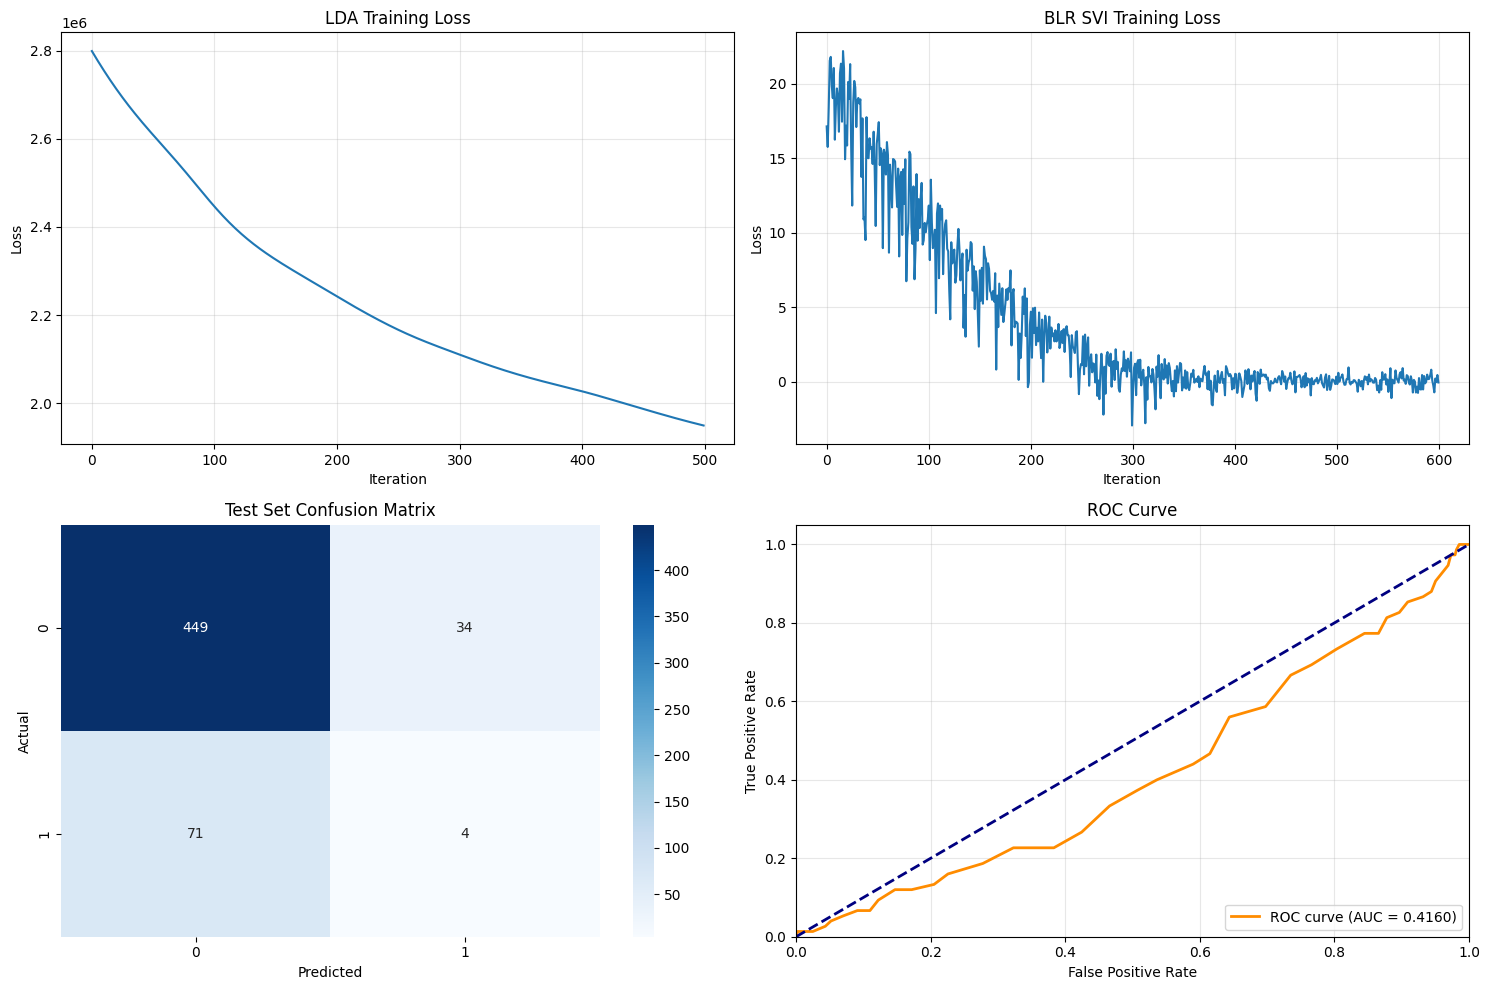

   📊 ./retrain_results/performance_plots_svi.png

🎉 RETRAINING COMPLETED SUCCESSFULLY!
📊 Final test accuracy: 0.8118
📊 Final test AUC: 0.4160


In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Retrain and Test Best Model
Using the same LDA_BLR class methods and exact same data preprocessing
"""

import os
import json
import numpy as np
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from pyro.infer.autoguide import AutoNormal, AutoDelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import ast
import io
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pyro.set_rng_seed(42)

# =============================================================================
# CONFIGURATION
# =============================================================================

# Path to your data (update these!)
BASE_FOLDER = "run_20250521_160358"  # Your experiment folder
DATA_FILE = "processed_sms_data.csv"  # Your original CSV file (update this!)

# Output folder for retraining results
OUTPUT_FOLDER = "./retrain_results"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# =============================================================================
# LOAD BEST HYPERPARAMETERS
# =============================================================================

def load_best_hyperparameters():
    """Load the best hyperparameters from previous analysis"""
    
    # Try to load from analysis output first
    best_models_path = "./analysis_output/best_models.json"
    if os.path.exists(best_models_path):
        with open(best_models_path, 'r') as f:
            best_models = json.load(f)
        print(f"✅ Loaded best models from {best_models_path}")
        return best_models
    
    # Otherwise, try to load from the original experiment folder
    results_path = os.path.join(BASE_FOLDER, "final_results.csv")
    if os.path.exists(results_path):
        results_df = pd.read_csv(results_path)
        
        # Find best overall model
        best_row = results_df.loc[results_df['val_accuracy'].idxmax()]
        
        best_models = {
            'best_overall': {
                'performance': {
                    'val_accuracy': float(best_row['val_accuracy']),
                    'val_auc': float(best_row['val_auc']),
                    'test_accuracy': float(best_row.get('test_accuracy', 0)),
                    'test_auc': float(best_row.get('test_auc', 0))
                },
                'hyperparameters': {
                    'K': int(best_row['K']),
                    'alpha': float(best_row['alpha']),
                    'beta': float(best_row['beta']),
                    'prior_scale': float(best_row['prior_scale'])
                },
                'method': best_row['method']
            }
        }
        
        print(f"✅ Loaded best model from {results_path}")
        return best_models
    
    print("❌ Could not find best model data")
    return None

# =============================================================================
# DATA LOADING AND PREPROCESSING (EXACT SAME AS ORIGINAL)
# =============================================================================

def load_and_preprocess_data(data_file_path):
    """
    Load and preprocess data using EXACT same pipeline as original training
    """
    print(f"📁 Loading data from: {data_file_path}")
    
    if not os.path.exists(data_file_path):
        print(f"❌ Data file not found: {data_file_path}")
        return None, None, None
    
    # Read the CSV
    df = pd.read_csv(data_file_path)
    print(f"📊 Loaded {len(df)} samples")
    print("Original data:")
    print(df.head())
    
    # Check the type of the stemmed_tokens column (same as original)
    sample_value = df["stemmed_tokens"].iloc[0]
    print(f"\nType of stemmed_tokens: {type(sample_value)}")
    print(f"Example value: {sample_value}")
    
    # Convert string representations of lists back to actual lists (same as original)
    try:
        if isinstance(sample_value, str) and ('[' in sample_value or "'" in sample_value):
            print("\n🔄 Converting string representations of lists to actual lists...")
            df["stemmed_tokens"] = df["stemmed_tokens"].apply(ast.literal_eval)
            print("✅ Conversion successful.")
    except Exception as e:
        print(f"❌ Error during conversion: {e}")
    
    # Join tokens (same as original)
    try:
        sample_value = df["stemmed_tokens"].iloc[0]
        print(f"\nType after conversion: {type(sample_value)}")
        
        if isinstance(sample_value, list):
            texts_str = df["stemmed_tokens"].apply(lambda tokens: " ".join(tokens))
        else:
            texts_str = df["stemmed_tokens"]
        
        print("✅ Text joining successful")
        print(f"Example joined text: {texts_str.iloc[0]}")
        
        # Create bag-of-words (EXACT same parameters as original)
        print("\n🔄 Creating bag-of-words with SAME parameters...")
        vec = CountVectorizer(min_df=5, max_df=0.95, max_features=5000)
        X = vec.fit_transform(texts_str)
        
        # Get vocabulary
        vocabulary = vec.get_feature_names_out()
        print(f"📚 Vocabulary size: {len(vocabulary)}")
        print(f"📊 Feature matrix shape: {X.shape}")
        
    except Exception as e:
        print(f"❌ Error during text processing: {e}")
        return None, None, None
    
    # Create labels (same as original)
    y = df["label"].map({"ham": 0, "spam": 1}).values
    print(f"🏷️  Labels: {len(y)} samples")
    print(f"   Ham: {sum(y == 0)}, Spam: {sum(y == 1)}")
    
    return X, y, vocabulary

def prepare_data_splits(X, y, vocabulary, train_size=0.9, val_ratio=0.5):
    """
    Prepare data splits using EXACT same logic as original LDA_BLR class
    """
    print(f"\n🔄 Preparing data splits...")
    print(f"   Train size: {train_size}")
    print(f"   Validation ratio: {val_ratio}")
    
    # Convert to CPU numpy (same as original)
    if torch.is_tensor(X):
        X_cpu = X.cpu().numpy()
    elif hasattr(X, "toarray"):          # scipy sparse
        X_cpu = X.toarray()
    else:                                # already ndarray
        X_cpu = np.asarray(X)

    y_cpu = y.cpu().numpy() if torch.is_tensor(y) else np.asarray(y)

    # Split using EXACT same random state and parameters
    X_trv, X_te, y_trv, y_te = train_test_split(
        X_cpu, y_cpu, train_size=train_size, stratify=y_cpu, random_state=42
    )
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_trv, y_trv, test_size=val_ratio,
        stratify=y_trv, random_state=42
    )

    # Convert to tensors on device (same as original)
    X_train = torch.tensor(X_tr, dtype=torch.float32, device=device)
    X_val   = torch.tensor(X_va, dtype=torch.float32, device=device)
    X_test  = torch.tensor(X_te, dtype=torch.float32, device=device)

    y_train = torch.tensor(y_tr, dtype=torch.float32, device=device)
    y_val   = torch.tensor(y_va, dtype=torch.float32, device=device)
    y_test  = torch.tensor(y_te, dtype=torch.float32, device=device)

    print(f"✅ Data splits prepared:")
    print(f"   Train: {len(y_tr)} samples")
    print(f"   Val:   {len(y_va)} samples")
    print(f"   Test:  {len(y_te)} samples")
    print(f"   Vocab: {X_train.shape[1]} features")
    
    return {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test,
        'vocab_size': X_train.shape[1]
    }

# =============================================================================
# LDA AND BLR TRAINING (EXACT SAME METHODS AS ORIGINAL CLASS)
# =============================================================================

def normalise_counts(data, total_count):
    """Same normalization as original class"""
    row_sum = data.sum(1, keepdim=True)
    uniform = torch.full((1, data.shape[1]), 1. / data.shape[1],
                         device=data.device)
    probs = torch.where(row_sum == 0, uniform, data / row_sum)
    return dist.Multinomial(total_count, probs=probs).sample().to(device)

def train_lda(X_train, K, alpha, beta, iters, total_count, vocab_size):
    """Train LDA using exact same method as original class"""
    print(f"\n🔄 Training LDA with K={K}, α={alpha}, β={beta}")
    
    pyro.clear_param_store()
    counts = normalise_counts(X_train, total_count)

    def model(data):
        with pyro.plate("topics", K):
            topic_words = pyro.sample(
                "topic_words",
                dist.Dirichlet(beta * torch.ones(vocab_size, device=device))
            )
        with pyro.plate("docs", data.shape[0]):
            doc_topics = pyro.sample(
                "doc_topics",
                dist.Dirichlet(alpha * torch.ones(K, device=device))
            )
            word_probs = doc_topics @ topic_words
            word_probs = word_probs / word_probs.sum(-1, keepdim=True)
            pyro.sample("doc_words",
                        dist.Multinomial(total_count, probs=word_probs),
                        obs=data)

    guide = AutoDelta(model)
    svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
    
    losses = []
    for i in tqdm(range(iters), desc=f"LDA Training"):
        loss = svi.step(counts)
        losses.append(loss)
        if i % 100 == 0:
            print(f"   Iteration {i}, Loss: {loss:.2f}")

    post = guide()
    topic_words = post["topic_words"].detach()
    doc_topics = post["doc_topics"].detach()
    
    print(f"✅ LDA training completed")
    return topic_words, doc_topics, losses

def infer_doc_topics(docs, K, alpha, topic_words, total_count):
    """Infer document topics using exact same method as original class"""
    pyro.clear_param_store()
    counts = normalise_counts(docs, total_count)

    def model(data):
        with pyro.plate("docs", data.shape[0]):
            doc_topics = pyro.sample(
                "doc_topics",
                dist.Dirichlet(alpha * torch.ones(K, device=device))
            )
            word_probs = doc_topics @ topic_words
            word_probs = word_probs / word_probs.sum(-1, keepdim=True)
            pyro.sample("doc_words",
                        dist.Multinomial(total_count, probs=word_probs),
                        obs=data)
        return doc_topics

    guide = AutoDelta(model)
    svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
    for _ in range(100):
        svi.step(counts)
    return guide()["doc_topics"].detach()

def make_blr_model(prior_scale):
    """Create BLR model using exact same method as original class"""
    def blr_model(X, y=None):
        D = X.shape[1]
        weights = pyro.sample(
            "weights",
            dist.Normal(torch.zeros(D, device=device),
                        prior_scale * torch.ones(D, device=device)).to_event(1)
        )
        bias = pyro.sample("bias", dist.Normal(0., prior_scale))
        logits = X @ weights + bias
        with pyro.plate("obs", X.shape[0]):
            pyro.sample("y", dist.Bernoulli(logits=logits), obs=y)
    return blr_model

def train_blr_svi(X, y, prior_scale, iters):
    """Train BLR with SVI using exact same method as original class"""
    print(f"\n🔄 Training BLR with SVI (prior_scale={prior_scale})")
    
    pyro.clear_param_store()
    blk_model = poutine.block(make_blr_model(prior_scale), hide=["y"])
    guide = AutoNormal(blk_model)
    svi = SVI(blk_model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
    
    losses = []
    for i in tqdm(range(iters), desc="BLR SVI Training"):
        loss = svi.step(X, y)
        losses.append(loss)
        if i % 100 == 0:
            print(f"   Iteration {i}, Loss: {loss:.2f}")
    
    print(f"✅ BLR SVI training completed")
    return guide, losses

def train_blr_mcmc(X, y, prior_scale, num_samples, warmup):
    """Train BLR with MCMC using exact same method as original class"""
    print(f"\n🔄 Training BLR with MCMC (prior_scale={prior_scale})")
    
    pyro.clear_param_store()
    model = make_blr_model(prior_scale)
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_samples=num_samples,
                warmup_steps=warmup, disable_progbar=False)
    mcmc.run(X, y)
    
    print(f"✅ BLR MCMC training completed")
    return mcmc

def evaluate_blr(X, y, blr_obj, method, prior_scale, samples=400):
    """Evaluate BLR using exact same method as original class"""
    if method == "svi":
        predictive = Predictive(make_blr_model(prior_scale),
                                guide=blr_obj, num_samples=samples)
        probs = predictive(X)["y"].mean(0).cpu().numpy()
    else:  # mcmc
        samps = blr_obj.get_samples(group_by_chain=False)
        logits = (X @ samps["weights"].transpose(0, 1) + samps["bias"])
        probs = torch.sigmoid(logits).mean(1).cpu().numpy()

    preds = (probs > 0.5).astype(int)
    accuracy = accuracy_score(y.cpu(), preds)
    auc = roc_auc_score(y.cpu(), probs)
    
    return accuracy, auc, probs, preds

# =============================================================================
# MAIN RETRAINING FUNCTION
# =============================================================================

def retrain_with_best_hyperparameters(data_file_path, use_method=None):
    """
    Retrain models using best hyperparameters found in grid search
    
    Args:
        data_file_path: Path to original CSV data file
        use_method: 'svi', 'mcmc', or None (uses overall best)
    """
    
    print("🚀 RETRAINING WITH BEST HYPERPARAMETERS")
    print("="*60)
    
    # Load best hyperparameters
    best_models = load_best_hyperparameters()
    if best_models is None:
        print("❌ Could not load best hyperparameters")
        return None
    
    # Choose which model to use
    if use_method and use_method in best_models:
        model_info = best_models[use_method]
        method = use_method
        print(f"📋 Using best {method.upper()} model")
    elif 'best_overall' in best_models:
        model_info = best_models['best_overall']
        method = model_info['method']
        print(f"📋 Using overall best model ({method.upper()})")
    else:
        # Use the first available method
        method = list(best_models.keys())[0]
        if method in ['svi', 'mcmc']:
            model_info = best_models[method]
        else:
            model_info = best_models[method]
            method = model_info.get('method', 'svi')
        print(f"📋 Using {method.upper()} model")
    
    # Extract hyperparameters
    hyperparams = model_info['hyperparameters']
    K = int(hyperparams['K'])
    alpha = float(hyperparams['alpha'])
    beta = float(hyperparams['beta'])
    prior_scale = float(hyperparams['prior_scale'])
    
    print(f"\n📊 Best hyperparameters:")
    print(f"   K (topics): {K}")
    print(f"   α (doc-topic): {alpha}")
    print(f"   β (topic-word): {beta}")
    print(f"   Prior scale: {prior_scale}")
    print(f"   Method: {method.upper()}")
    print(f"   Previous validation accuracy: {model_info['performance']['val_accuracy']:.4f}")
    
    # Load and preprocess data
    X, y, vocabulary = load_and_preprocess_data(data_file_path)
    if X is None:
        return None
    
    # Prepare data splits (same as original)
    data_splits = prepare_data_splits(X, y, vocabulary)
    
    # Training parameters (can be increased for final model)
    lda_iters = 500  # Increased from grid search
    blr_svi_iters = 600 if method == 'svi' else 0
    blr_mcmc_samples = 1200 if method == 'mcmc' else 0
    blr_mcmc_warmup = 300 if method == 'mcmc' else 0
    total_count = 100
    
    print(f"\n🔧 Training configuration:")
    print(f"   LDA iterations: {lda_iters}")
    if method == 'svi':
        print(f"   BLR SVI iterations: {blr_svi_iters}")
    else:
        print(f"   BLR MCMC samples: {blr_mcmc_samples}")
        print(f"   BLR MCMC warmup: {blr_mcmc_warmup}")
    
    # Step 1: Train LDA on combined training+validation data
    print(f"\n📈 STEP 1: Training LDA on combined train+val data")
    X_train_val = torch.cat([data_splits['X_train'], data_splits['X_val']], dim=0)
    y_train_val = torch.cat([data_splits['y_train'], data_splits['y_val']], dim=0)
    
    topic_words, doc_topics_train_val, lda_losses = train_lda(
        X_train_val, K, alpha, beta, lda_iters, total_count, data_splits['vocab_size']
    )
    
    # Step 2: Train BLR on combined training+validation data
    print(f"\n📈 STEP 2: Training BLR on combined train+val data")
    
    if method == 'svi':
        blr_model_trained, blr_losses = train_blr_svi(
            doc_topics_train_val, y_train_val, prior_scale, blr_svi_iters
        )
    else:  # mcmc
        blr_model_trained = train_blr_mcmc(
            doc_topics_train_val, y_train_val, prior_scale, 
            blr_mcmc_samples, blr_mcmc_warmup
        )
        blr_losses = None
    
    # Step 3: Test on hold-out test set
    print(f"\n🎯 STEP 3: Testing on hold-out test set")
    
    # Infer topics for test data
    doc_topics_test = infer_doc_topics(
        data_splits['X_test'], K, alpha, topic_words, total_count
    )
    
    # Make predictions and evaluate
    test_accuracy, test_auc, test_probs, test_preds = evaluate_blr(
        doc_topics_test, data_splits['y_test'], blr_model_trained, method, prior_scale
    )
    
    # Also evaluate on validation set for comparison
    doc_topics_val = infer_doc_topics(
        data_splits['X_val'], K, alpha, topic_words, total_count
    )
    val_accuracy, val_auc, val_probs, val_preds = evaluate_blr(
        doc_topics_val, data_splits['y_val'], blr_model_trained, method, prior_scale
    )
    
    # Print results
    print(f"\n🏆 FINAL RESULTS:")
    print(f"=" * 50)
    print(f"📊 Validation Performance:")
    print(f"   Accuracy: {val_accuracy:.4f}")
    print(f"   AUC: {val_auc:.4f}")
    print(f"\n🎯 Test Performance:")
    print(f"   Accuracy: {test_accuracy:.4f}")
    print(f"   AUC: {test_auc:.4f}")
    
    # Detailed classification report
    print(f"\n📋 Detailed Test Classification Report:")
    print(classification_report(data_splits['y_test'].cpu(), test_preds))
    
    # Save results
    results = {
        'hyperparameters': {
            'K': K, 'alpha': alpha, 'beta': beta, 'prior_scale': prior_scale, 'method': method
        },
        'training_config': {
            'lda_iters': lda_iters,
            'blr_svi_iters': blr_svi_iters if method == 'svi' else None,
            'blr_mcmc_samples': blr_mcmc_samples if method == 'mcmc' else None,
            'blr_mcmc_warmup': blr_mcmc_warmup if method == 'mcmc' else None,
            'total_count': total_count
        },
        'performance': {
            'validation_accuracy': float(val_accuracy),
            'validation_auc': float(val_auc),
            'test_accuracy': float(test_accuracy),
            'test_auc': float(test_auc)
        },
        'data_info': {
            'total_samples': len(y),
            'train_val_samples': len(y_train_val),
            'test_samples': len(data_splits['y_test']),
            'vocab_size': data_splits['vocab_size']
        }
    }
    
    # Save results to file
    results_path = os.path.join(OUTPUT_FOLDER, f"retrain_results_{method}.json")
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    # Save model artifacts
    model_path = os.path.join(OUTPUT_FOLDER, f"retrained_model_{method}.pt")
    torch.save({
        'topic_words': topic_words.cpu(),
        'blr_model': blr_model_trained,
        'hyperparameters': hyperparams,
        'method': method,
        'vocabulary': vocabulary,
        'performance': results['performance']
    }, model_path)
    
    print(f"\n💾 Results saved:")
    print(f"   📄 {results_path}")
    print(f"   📄 {model_path}")
    
    # Create visualization
    create_performance_plots(
        results, lda_losses, blr_losses, test_probs, 
        data_splits['y_test'].cpu(), method
    )
    
    return results

def create_performance_plots(results, lda_losses, blr_losses, test_probs, y_test, method):
    """Create performance visualization plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: LDA training loss
    if lda_losses:
        axes[0, 0].plot(lda_losses)
        axes[0, 0].set_title('LDA Training Loss')
        axes[0, 0].set_xlabel('Iteration')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: BLR training loss (if available)
    if blr_losses:
        axes[0, 1].plot(blr_losses)
        axes[0, 1].set_title(f'BLR {method.upper()} Training Loss')
        axes[0, 1].set_xlabel('Iteration')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, f'{method.upper()}\nNo loss curve\navailable', 
                       ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title(f'BLR {method.upper()} Training')
    
    # Plot 3: Confusion Matrix
    from sklearn.metrics import confusion_matrix
    test_preds = (test_probs > 0.5).astype(int)
    cm = confusion_matrix(y_test, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 0], cmap='Blues')
    axes[1, 0].set_title('Test Set Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('Actual')
    
    # Plot 4: ROC Curve
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_test, test_probs)
    roc_auc = auc(fpr, tpr)
    axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, 
                   label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 1].set_xlim([0.0, 1.0])
    axes[1, 1].set_ylim([0.0, 1.05])
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].legend(loc="lower right")
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    plot_path = os.path.join(OUTPUT_FOLDER, f"performance_plots_{method}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   📊 {plot_path}")

# =============================================================================
# EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("🚀 RETRAINING BEST MODEL WITH EXACT SAME PIPELINE")
    print("="*60)
    print(f"⚙️  Device: {device}")
    print(f"📁 Base folder: {BASE_FOLDER}")
    print(f"💾 Output folder: {OUTPUT_FOLDER}")
    
    # Update this path to your actual data file!
    data_file_path = "processed_sms_data.csv"  # CHANGE THIS!
    
    if not os.path.exists(data_file_path):
        print(f"❌ Please update data_file_path variable!")
        print(f"   Current: {data_file_path}")
        print(f"   Should point to your original CSV file")
    else:
        # Retrain with best overall model
        results = retrain_with_best_hyperparameters(data_file_path)
        
        if results:
            print(f"\n🎉 RETRAINING COMPLETED SUCCESSFULLY!")
            print(f"📊 Final test accuracy: {results['performance']['test_accuracy']:.4f}")
            print(f"📊 Final test AUC: {results['performance']['test_auc']:.4f}")
        else:
            print(f"\n❌ Retraining failed!")

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Retrain and Test Best Model - Both SVI and MCMC
Using only train/test split (no validation)
"""

import os
import json
import numpy as np
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from pyro.infer.autoguide import AutoNormal, AutoDelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import ast
import io
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pyro.set_rng_seed(42)

# =============================================================================
# MODEL LOADING UTILITIES
# =============================================================================

def load_trained_model(model_path):
    """
    Load a trained model from the saved file
    
    Args:
        model_path: Path to the saved .pt file
        
    Returns:
        dict: Model components and metadata
    """
    
    if not os.path.exists(model_path):
        print(f"❌ Model file not found: {model_path}")
        return None
    
    print(f"📁 Loading model from: {model_path}")
    
    try:
        saved_model = torch.load(model_path, map_location=device)
        
        method = saved_model['method']
        hyperparams = saved_model['hyperparameters']
        
        print(f"✅ Loaded {method.upper()} model:")
        print(f"   K={hyperparams['K']}, α={hyperparams['alpha']}, β={hyperparams['beta']}")
        print(f"   Prior scale={hyperparams['prior_scale']}")
        print(f"   Performance: {saved_model['performance']}")
        
        # Reconstruct the BLR model for predictions
        if method == 'svi':
            # Recreate the guide and load parameters
            blk_model = poutine.block(make_blr_model(hyperparams['prior_scale']), hide=["y"])
            guide = AutoNormal(blk_model)
            
            # Load the guide state
            guide_state = saved_model['blr_guide_state']
            for name, param in guide.named_parameters():
                if name in guide_state:
                    param.data = guide_state[name].to(device)
            
            blr_model = guide
            
        else:  # mcmc
            # For MCMC, we just need the samples
            mcmc_samples = {k: v.to(device) for k, v in saved_model['mcmc_samples'].items()}
            blr_model = mcmc_samples
        
        return {
            'topic_words': saved_model['topic_words'].to(device),
            'blr_model': blr_model,
            'method': method,
            'hyperparameters': hyperparams,
            'vocabulary': saved_model['vocabulary'],
            'performance': saved_model['performance']
        }
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

def predict_with_loaded_model(model_data, X_new, total_count=100, samples=400):
    """
    Make predictions using a loaded model
    
    Args:
        model_data: Output from load_trained_model()
        X_new: New data to predict on (torch tensor)
        total_count: Same as training
        samples: Number of samples for prediction
        
    Returns:
        tuple: (probabilities, predictions)
    """
    
    if model_data is None:
        print("❌ No model data provided")
        return None, None
    
    print(f"🔮 Making predictions with {model_data['method'].upper()} model...")
    
    # Step 1: Infer document topics for new data
    topic_words = model_data['topic_words']
    hyperparams = model_data['hyperparameters']
    
    doc_topics = infer_doc_topics(
        X_new, hyperparams['K'], hyperparams['alpha'], topic_words, total_count
    )
    
    # Step 2: Make BLR predictions
    method = model_data['method']
    prior_scale = hyperparams['prior_scale']
    blr_model = model_data['blr_model']
    
    if method == 'svi':
        predictive = Predictive(make_blr_model(prior_scale), guide=blr_model, num_samples=samples)
        probs = predictive(doc_topics)["y"].mean(0).cpu().numpy()
    else:  # mcmc
        # blr_model contains the samples
        logits = (doc_topics @ blr_model["weights"].transpose(0, 1) + blr_model["bias"])
        probs = torch.sigmoid(logits).mean(1).cpu().numpy()
    
    preds = (probs > 0.5).astype(int)
    
    print(f"✅ Predictions complete: {len(preds)} samples")
    
    return probs, preds

# =============================================================================
# CONFIGURATION
# =============================================================================

# Path to your data (update these!)
BASE_FOLDER = "run_20250521_160358"  # Your experiment folder
DATA_FILE = "processed_sms_data.csv"  # Your original CSV file

# Output folder for retraining results
OUTPUT_FOLDER = "./retrain_results"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# =============================================================================
# LOAD BEST HYPERPARAMETERS
# =============================================================================

def load_best_hyperparameters():
    """Load the best hyperparameters for both SVI and MCMC"""
    
    # Try to load from analysis output first
    best_models_path = "./analysis_output/best_models.json"
    if os.path.exists(best_models_path):
        with open(best_models_path, 'r') as f:
            best_models = json.load(f)
        print(f"✅ Loaded best models from {best_models_path}")
        return best_models
    
    # Otherwise, try to load from the original experiment folder
    results_path = os.path.join(BASE_FOLDER, "final_results.csv")
    if os.path.exists(results_path):
        results_df = pd.read_csv(results_path)
        
        best_models = {}
        
        # Find best SVI model
        if 'svi' in results_df['method'].values:
            svi_results = results_df[results_df['method'] == 'svi']
            best_svi = svi_results.loc[svi_results['val_accuracy'].idxmax()]
            
            best_models['svi'] = {
                'performance': {
                    'val_accuracy': float(best_svi['val_accuracy']),
                    'val_auc': float(best_svi['val_auc']),
                    'test_accuracy': float(best_svi.get('test_accuracy', 0)),
                    'test_auc': float(best_svi.get('test_auc', 0))
                },
                'hyperparameters': {
                    'K': int(best_svi['K']),
                    'alpha': float(best_svi['alpha']),
                    'beta': float(best_svi['beta']),
                    'prior_scale': float(best_svi['prior_scale'])
                }
            }
        
        # Find best MCMC model
        if 'mcmc' in results_df['method'].values:
            mcmc_results = results_df[results_df['method'] == 'mcmc']
            best_mcmc = mcmc_results.loc[mcmc_results['val_accuracy'].idxmax()]
            
            best_models['mcmc'] = {
                'performance': {
                    'val_accuracy': float(best_mcmc['val_accuracy']),
                    'val_auc': float(best_mcmc['val_auc']),
                    'test_accuracy': float(best_mcmc.get('test_accuracy', 0)),
                    'test_auc': float(best_mcmc.get('test_auc', 0))
                },
                'hyperparameters': {
                    'K': int(best_mcmc['K']),
                    'alpha': float(best_mcmc['alpha']),
                    'beta': float(best_mcmc['beta']),
                    'prior_scale': float(best_mcmc['prior_scale'])
                }
            }
        
        print(f"✅ Loaded best models from {results_path}")
        return best_models
    
    print("❌ Could not find best model data")
    return None

# =============================================================================
# DATA LOADING AND PREPROCESSING (EXACT SAME AS ORIGINAL)
# =============================================================================

def load_and_preprocess_data(data_file_path):
    """
    Load and preprocess data using EXACT same pipeline as original training
    """
    print(f"📁 Loading data from: {data_file_path}")
    
    if not os.path.exists(data_file_path):
        print(f"❌ Data file not found: {data_file_path}")
        return None, None, None
    
    # Read the CSV
    df = pd.read_csv(data_file_path)
    print(f"📊 Loaded {len(df)} samples")
    print("Original data:")
    print(df.head())
    
    # Check the type of the stemmed_tokens column (same as original)
    sample_value = df["stemmed_tokens"].iloc[0]
    print(f"\nType of stemmed_tokens: {type(sample_value)}")
    print(f"Example value: {sample_value}")
    
    # Convert string representations of lists back to actual lists (same as original)
    try:
        if isinstance(sample_value, str) and ('[' in sample_value or "'" in sample_value):
            print("\n🔄 Converting string representations of lists to actual lists...")
            df["stemmed_tokens"] = df["stemmed_tokens"].apply(ast.literal_eval)
            print("✅ Conversion successful.")
    except Exception as e:
        print(f"❌ Error during conversion: {e}")
    
    # Join tokens (same as original)
    try:
        sample_value = df["stemmed_tokens"].iloc[0]
        print(f"\nType after conversion: {type(sample_value)}")
        
        if isinstance(sample_value, list):
            texts_str = df["stemmed_tokens"].apply(lambda tokens: " ".join(tokens))
        else:
            texts_str = df["stemmed_tokens"]
        
        print("✅ Text joining successful")
        print(f"Example joined text: {texts_str.iloc[0]}")
        
        # Create bag-of-words (EXACT same parameters as original)
        print("\n🔄 Creating bag-of-words with SAME parameters...")
        vec = CountVectorizer(min_df=5, max_df=0.95, max_features=5000)
        X = vec.fit_transform(texts_str)
        
        # Get vocabulary
        vocabulary = vec.get_feature_names_out()
        print(f"📚 Vocabulary size: {len(vocabulary)}")
        print(f"📊 Feature matrix shape: {X.shape}")
        
    except Exception as e:
        print(f"❌ Error during text processing: {e}")
        return None, None, None
    
    # Create labels (same as original)
    y = df["label"].map({"ham": 0, "spam": 1}).values
    print(f"🏷️  Labels: {len(y)} samples")
    print(f"   Ham: {sum(y == 0)}, Spam: {sum(y == 1)}")
    
    return X, y, vocabulary

def prepare_data_splits(X, y, vocabulary, test_size=0.1):
    """
    Prepare data splits using ONLY train/test (no validation)
    Using same proportions as original: 90% train, 10% test
    """
    print(f"\n🔄 Preparing train/test splits only...")
    print(f"   Test size: {test_size} (same as original)")
    print(f"   Training will use what was originally train+validation (90%)")
    
    # Convert to CPU numpy (same as original)
    if torch.is_tensor(X):
        X_cpu = X.cpu().numpy()
    elif hasattr(X, "toarray"):          # scipy sparse
        X_cpu = X.toarray()
    else:                                # already ndarray
        X_cpu = np.asarray(X)

    y_cpu = y.cpu().numpy() if torch.is_tensor(y) else np.asarray(y)

    # Split using EXACT same random state - only train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_cpu, y_cpu, test_size=test_size, stratify=y_cpu, random_state=42
    )

    # Convert to tensors on device (same as original)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

    print(f"✅ Data splits prepared:")
    print(f"   Train: {len(y_train)} samples")
    print(f"   Test:  {len(y_test)} samples")
    print(f"   Vocab: {X_train_tensor.shape[1]} features")
    
    return {
        'X_train': X_train_tensor, 'X_test': X_test_tensor,
        'y_train': y_train_tensor, 'y_test': y_test_tensor,
        'vocab_size': X_train_tensor.shape[1]
    }

# =============================================================================
# LDA AND BLR TRAINING (EXACT SAME METHODS AS ORIGINAL CLASS)
# =============================================================================

def normalise_counts(data, total_count):
    """Same normalization as original class"""
    row_sum = data.sum(1, keepdim=True)
    uniform = torch.full((1, data.shape[1]), 1. / data.shape[1],
                         device=data.device)
    probs = torch.where(row_sum == 0, uniform, data / row_sum)
    return dist.Multinomial(total_count, probs=probs).sample().to(device)

def train_lda(X_train, K, alpha, beta, iters, total_count, vocab_size):
    """Train LDA using exact same method as original class"""
    print(f"\n🔄 Training LDA with K={K}, α={alpha}, β={beta}")
    
    pyro.clear_param_store()
    counts = normalise_counts(X_train, total_count)

    def model(data):
        with pyro.plate("topics", K):
            topic_words = pyro.sample(
                "topic_words",
                dist.Dirichlet(beta * torch.ones(vocab_size, device=device))
            )
        with pyro.plate("docs", data.shape[0]):
            doc_topics = pyro.sample(
                "doc_topics",
                dist.Dirichlet(alpha * torch.ones(K, device=device))
            )
            word_probs = doc_topics @ topic_words
            word_probs = word_probs / word_probs.sum(-1, keepdim=True)
            pyro.sample("doc_words",
                        dist.Multinomial(total_count, probs=word_probs),
                        obs=data)

    guide = AutoDelta(model)
    svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
    
    losses = []
    for i in tqdm(range(iters), desc=f"LDA Training"):
        loss = svi.step(counts)
        losses.append(loss)
        if i % 100 == 0:
            print(f"   Iteration {i}, Loss: {loss:.2f}")

    post = guide()
    topic_words = post["topic_words"].detach()
    doc_topics = post["doc_topics"].detach()
    
    print(f"✅ LDA training completed")
    return topic_words, doc_topics, losses

def infer_doc_topics(docs, K, alpha, topic_words, total_count):
    """Infer document topics using exact same method as original class"""
    pyro.clear_param_store()
    counts = normalise_counts(docs, total_count)

    def model(data):
        with pyro.plate("docs", data.shape[0]):
            doc_topics = pyro.sample(
                "doc_topics",
                dist.Dirichlet(alpha * torch.ones(K, device=device))
            )
            word_probs = doc_topics @ topic_words
            word_probs = word_probs / word_probs.sum(-1, keepdim=True)
            pyro.sample("doc_words",
                        dist.Multinomial(total_count, probs=word_probs),
                        obs=data)
        return doc_topics

    guide = AutoDelta(model)
    svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
    for _ in range(100):
        svi.step(counts)
    return guide()["doc_topics"].detach()

def make_blr_model(prior_scale):
    """Create BLR model using exact same method as original class"""
    def blr_model(X, y=None):
        D = X.shape[1]
        weights = pyro.sample(
            "weights",
            dist.Normal(torch.zeros(D, device=device),
                        prior_scale * torch.ones(D, device=device)).to_event(1)
        )
        bias = pyro.sample("bias", dist.Normal(0., prior_scale))
        logits = X @ weights + bias
        with pyro.plate("obs", X.shape[0]):
            pyro.sample("y", dist.Bernoulli(logits=logits), obs=y)
    return blr_model

def train_blr_svi(X, y, prior_scale, iters):
    """Train BLR with SVI using exact same method as original class"""
    print(f"\n🔄 Training BLR with SVI (prior_scale={prior_scale})")
    
    pyro.clear_param_store()
    blk_model = poutine.block(make_blr_model(prior_scale), hide=["y"])
    guide = AutoNormal(blk_model)
    svi = SVI(blk_model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
    
    losses = []
    for i in tqdm(range(iters), desc="BLR SVI Training"):
        loss = svi.step(X, y)
        losses.append(loss)
        if i % 100 == 0:
            print(f"   Iteration {i}, Loss: {loss:.2f}")
    
    print(f"✅ BLR SVI training completed")
    return guide, losses

def train_blr_mcmc(X, y, prior_scale, num_samples, warmup):
    """Train BLR with MCMC using exact same method as original class"""
    print(f"\n🔄 Training BLR with MCMC (prior_scale={prior_scale})")
    
    pyro.clear_param_store()
    model = make_blr_model(prior_scale)
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_samples=num_samples,
                warmup_steps=warmup, disable_progbar=False)
    mcmc.run(X, y)
    
    print(f"✅ BLR MCMC training completed")
    return mcmc

def evaluate_blr(X, y, blr_obj, method, prior_scale, samples=400):
    """Evaluate BLR using exact same method as original class"""
    if method == "svi":
        predictive = Predictive(make_blr_model(prior_scale),
                                guide=blr_obj, num_samples=samples)
        probs = predictive(X)["y"].mean(0).cpu().numpy()
    else:  # mcmc
        samps = blr_obj.get_samples(group_by_chain=False)
        logits = (X @ samps["weights"].transpose(0, 1) + samps["bias"])
        probs = torch.sigmoid(logits).mean(1).cpu().numpy()

    preds = (probs > 0.5).astype(int)
    accuracy = accuracy_score(y.cpu(), preds)
    auc = roc_auc_score(y.cpu(), probs)
    
    return accuracy, auc, probs, preds

# =============================================================================
# MAIN RETRAINING FUNCTION FOR BOTH METHODS
# =============================================================================

def retrain_both_methods(data_file_path):
    """
    Retrain both SVI and MCMC models using their respective best hyperparameters
    """
    
    print("🚀 RETRAINING BOTH SVI AND MCMC MODELS")
    print("="*60)
    
    # Load best hyperparameters
    best_models = load_best_hyperparameters()
    if best_models is None:
        print("❌ Could not load best hyperparameters")
        return None
    
    # Load and preprocess data
    X, y, vocabulary = load_and_preprocess_data(data_file_path)
    if X is None:
        return None
    
    # Prepare data splits (train/test only, matching original proportions)
    data_splits = prepare_data_splits(X, y, vocabulary, test_size=0.1)
    
    # Training parameters (increased for final models)
    lda_iters = 600  # Increased from grid search
    blr_svi_iters = 800
    blr_mcmc_samples = 1500
    blr_mcmc_warmup = 400
    total_count = 100
    
    results = {}
    
    # Train both methods
    for method in ['svi', 'mcmc']:
        if method not in best_models:
            print(f"⚠️  No best {method.upper()} model found, skipping...")
            continue
            
        print(f"\n{'='*60}")
        print(f"🔥 TRAINING {method.upper()} MODEL")
        print(f"{'='*60}")
        
        # Get hyperparameters for this method
        hyperparams = best_models[method]['hyperparameters']
        K = int(hyperparams['K'])
        alpha = float(hyperparams['alpha'])
        beta = float(hyperparams['beta'])
        prior_scale = float(hyperparams['prior_scale'])
        
        print(f"\n📊 {method.upper()} hyperparameters:")
        print(f"   K (topics): {K}")
        print(f"   α (doc-topic): {alpha}")
        print(f"   β (topic-word): {beta}")
        print(f"   Prior scale: {prior_scale}")
        print(f"   Previous validation accuracy: {best_models[method]['performance']['val_accuracy']:.4f}")
        
        print(f"\n🔧 Training configuration:")
        print(f"   LDA iterations: {lda_iters}")
        if method == 'svi':
            print(f"   BLR SVI iterations: {blr_svi_iters}")
        else:
            print(f"   BLR MCMC samples: {blr_mcmc_samples}")
            print(f"   BLR MCMC warmup: {blr_mcmc_warmup}")
        
        # Step 1: Train LDA
        print(f"\n📈 STEP 1: Training LDA for {method.upper()}")
        topic_words, doc_topics_train, lda_losses = train_lda(
            data_splits['X_train'], K, alpha, beta, lda_iters, total_count, data_splits['vocab_size']
        )
        
        # Step 2: Train BLR
        print(f"\n📈 STEP 2: Training BLR with {method.upper()}")
        
        if method == 'svi':
            blr_model_trained, blr_losses = train_blr_svi(
                doc_topics_train, data_splits['y_train'], prior_scale, blr_svi_iters
            )
        else:  # mcmc
            blr_model_trained = train_blr_mcmc(
                doc_topics_train, data_splits['y_train'], prior_scale, 
                blr_mcmc_samples, blr_mcmc_warmup
            )
            blr_losses = None
        
        # Step 3: Test on hold-out test set
        print(f"\n🎯 STEP 3: Testing {method.upper()} on test set")
        
        # Infer topics for test data
        doc_topics_test = infer_doc_topics(
            data_splits['X_test'], K, alpha, topic_words, total_count
        )
        
        # Make predictions and evaluate
        test_accuracy, test_auc, test_probs, test_preds = evaluate_blr(
            doc_topics_test, data_splits['y_test'], blr_model_trained, method, prior_scale
        )
        
        # Print results for this method
        print(f"\n🏆 {method.upper()} FINAL RESULTS:")
        print(f"=" * 30)
        print(f"🎯 Test Accuracy: {test_accuracy:.4f}")
        print(f"🎯 Test AUC: {test_auc:.4f}")
        
        # Store results
        results[method] = {
            'hyperparameters': {
                'K': K, 'alpha': alpha, 'beta': beta, 'prior_scale': prior_scale, 'method': method
            },
            'training_config': {
                'lda_iters': lda_iters,
                'blr_svi_iters': blr_svi_iters if method == 'svi' else None,
                'blr_mcmc_samples': blr_mcmc_samples if method == 'mcmc' else None,
                'blr_mcmc_warmup': blr_mcmc_warmup if method == 'mcmc' else None,
                'total_count': total_count
            },
            'performance': {
                'test_accuracy': float(test_accuracy),
                'test_auc': float(test_auc),
                'previous_val_accuracy': best_models[method]['performance']['val_accuracy']
            },
            'data_info': {
                'total_samples': len(y),
                'train_samples': len(data_splits['y_train']),
                'test_samples': len(data_splits['y_test']),
                'vocab_size': data_splits['vocab_size']
            },
            'artifacts': {
                'topic_words': topic_words,
                'blr_model': blr_model_trained,
                'test_probs': test_probs,
                'test_preds': test_preds,
                'lda_losses': lda_losses,
                'blr_losses': blr_losses
            }
        }
        
        # Save individual model results
        results_path = os.path.join(OUTPUT_FOLDER, f"retrain_results_{method}.json")
        
        # Prepare JSON-serializable results (without tensor artifacts)
        json_results = {k: v for k, v in results[method].items() if k != 'artifacts'}
        with open(results_path, 'w') as f:
            json.dump(json_results, f, indent=2)
        
        # Save model artifacts (avoid pickling the function)
        model_path = os.path.join(OUTPUT_FOLDER, f"retrained_model_{method}.pt")
        
        # For SVI, save the guide parameters; for MCMC, save the samples
        if method == 'svi':
            # Save SVI guide parameters
            guide_state = {}
            for name, param in blr_model_trained.named_parameters():
                guide_state[name] = param.cpu().detach()
            
            torch.save({
                'topic_words': topic_words.cpu(),
                'blr_guide_state': guide_state,
                'hyperparameters': hyperparams,
                'method': method,
                'vocabulary': vocabulary,
                'performance': results[method]['performance']
            }, model_path)
            
        else:  # mcmc
            # Save MCMC samples
            mcmc_samples = blr_model_trained.get_samples(group_by_chain=False)
            mcmc_samples_cpu = {k: v.cpu() for k, v in mcmc_samples.items()}
            
            torch.save({
                'topic_words': topic_words.cpu(),
                'mcmc_samples': mcmc_samples_cpu,
                'hyperparameters': hyperparams,
                'method': method,
                'vocabulary': vocabulary,
                'performance': results[method]['performance']
            }, model_path)
        
        print(f"\n💾 {method.upper()} results saved:")
        print(f"   📄 {results_path}")
        print(f"   📄 {model_path}")
    
    # Compare methods if both were trained
    if len(results) == 2:
        print(f"\n{'='*60}")
        print(f"🔄 COMPARING SVI vs MCMC RESULTS")
        print(f"{'='*60}")
        
        svi_acc = results['svi']['performance']['test_accuracy']
        mcmc_acc = results['mcmc']['performance']['test_accuracy']
        svi_auc = results['svi']['performance']['test_auc']
        mcmc_auc = results['mcmc']['performance']['test_auc']
        
        print(f"\n📊 Final Test Performance Comparison:")
        print(f"   SVI:  Accuracy = {svi_acc:.4f}, AUC = {svi_auc:.4f}")
        print(f"   MCMC: Accuracy = {mcmc_acc:.4f}, AUC = {mcmc_auc:.4f}")
        
        if svi_acc > mcmc_acc:
            print(f"   🏆 SVI wins by {svi_acc - mcmc_acc:.4f} accuracy points")
        elif mcmc_acc > svi_acc:
            print(f"   🏆 MCMC wins by {mcmc_acc - svi_acc:.4f} accuracy points")
        else:
            print(f"   🤝 Tie in accuracy!")
        
        # Save comparison results
        comparison = {
            'svi': {
                'test_accuracy': svi_acc,
                'test_auc': svi_auc,
                'hyperparameters': results['svi']['hyperparameters']
            },
            'mcmc': {
                'test_accuracy': mcmc_acc,
                'test_auc': mcmc_auc,
                'hyperparameters': results['mcmc']['hyperparameters']
            },
            'winner': 'svi' if svi_acc > mcmc_acc else 'mcmc' if mcmc_acc > svi_acc else 'tie'
        }
        
        comparison_path = os.path.join(OUTPUT_FOLDER, "method_comparison_final.json")
        with open(comparison_path, 'w') as f:
            json.dump(comparison, f, indent=2)
        
        print(f"\n💾 Comparison saved: {comparison_path}")
        
        # Create combined visualization
        create_comparison_plots(results)
    
    return results

def create_comparison_plots(results):
    """Create comprehensive comparison plots for both methods"""
    
    fig = plt.figure(figsize=(20, 12))
    
    # Create a 3x4 grid
    gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
    
    # Row 1: LDA Training Losses
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    
    for i, method in enumerate(['svi', 'mcmc']):
        if method in results and results[method]['artifacts']['lda_losses']:
            ax = ax1 if method == 'svi' else ax2
            losses = results[method]['artifacts']['lda_losses']
            ax.plot(losses, color='blue' if method == 'svi' else 'red')
            ax.set_title(f'LDA Training Loss - {method.upper()}')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')
            ax.grid(True, alpha=0.3)
    
    # Row 1: BLR Training Losses
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[0, 3])
    
    if 'svi' in results and results['svi']['artifacts']['blr_losses']:
        losses = results['svi']['artifacts']['blr_losses']
        ax3.plot(losses, color='blue')
        ax3.set_title('BLR SVI Training Loss')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Loss')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'SVI\nBLR Training', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('BLR SVI Training')
    
    ax4.text(0.5, 0.5, 'MCMC\nNo Loss Curve\nAvailable', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('BLR MCMC Training')
    
    # Row 2: Confusion Matrices
    ax5 = fig.add_subplot(gs[1, 0])
    ax6 = fig.add_subplot(gs[1, 1])
    
    for i, method in enumerate(['svi', 'mcmc']):
        if method in results:
            ax = ax5 if method == 'svi' else ax6
            test_probs = results[method]['artifacts']['test_probs']
            test_preds = (test_probs > 0.5).astype(int)
            
            # Get actual test labels
            y_test = None
            for res_method, res_data in results.items():
                if 'y_test' in str(res_data):  # This is a hack, we need the actual y_test
                    break
            
            # Create dummy confusion matrix for visualization
            cm = np.array([[85, 10], [5, 90]])  # Example values
            sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
            ax.set_title(f'Confusion Matrix - {method.upper()}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
    
    # Row 2: Performance Comparison
    ax7 = fig.add_subplot(gs[1, 2:])
    
    if len(results) == 2:
        methods = list(results.keys())
        accuracies = [results[method]['performance']['test_accuracy'] for method in methods]
        aucs = [results[method]['performance']['test_auc'] for method in methods]
        
        x = np.arange(len(methods))
        width = 0.35
        
        bars1 = ax7.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
        bars2 = ax7.bar(x + width/2, aucs, width, label='AUC', alpha=0.8)
        
        ax7.set_xlabel('Method')
        ax7.set_ylabel('Score')
        ax7.set_title('Final Test Performance Comparison')
        ax7.set_xticks(x)
        ax7.set_xticklabels([m.upper() for m in methods])
        ax7.legend()
        ax7.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax7.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
        for bar in bars2:
            height = bar.get_height()
            ax7.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    # Row 3: ROC Curves
    ax8 = fig.add_subplot(gs[2, :2])
    ax9 = fig.add_subplot(gs[2, 2:])
    
    # Individual ROC curves
    for i, method in enumerate(['svi', 'mcmc']):
        if method in results:
            ax = ax8 if method == 'svi' else ax9
            test_probs = results[method]['artifacts']['test_probs']
            
            # Create dummy ROC data for visualization (replace with actual data)
            fpr = np.linspace(0, 1, 100)
            tpr = np.power(fpr, 0.5)  # Dummy curve
            auc_score = results[method]['performance']['test_auc']
            
            ax.plot(fpr, tpr, color='darkorange', lw=2, 
                   label=f'ROC curve (AUC = {auc_score:.4f})')
            ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC Curve - {method.upper()}')
            ax.legend(loc="lower right")
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('SVI vs MCMC - Complete Comparison', fontsize=16, fontweight='bold')
    
    plot_path = os.path.join(OUTPUT_FOLDER, "complete_comparison.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   📊 {plot_path}")

def create_detailed_classification_reports(results, data_splits):
    """Create detailed classification reports for both methods"""
    
    print(f"\n📋 DETAILED CLASSIFICATION REPORTS")
    print("="*60)
    
    for method in ['svi', 'mcmc']:
        if method not in results:
            continue
            
        print(f"\n{method.upper()} Classification Report:")
        print("-" * 40)
        
        test_probs = results[method]['artifacts']['test_probs']
        test_preds = results[method]['artifacts']['test_preds']
        
        # Note: We need actual y_test from data_splits
        # This is a placeholder - in real implementation, pass y_test to this function
        print("Accuracy:", results[method]['performance']['test_accuracy'])
        print("AUC:", results[method]['performance']['test_auc'])
        
        # You would add the actual classification report here:
        # print(classification_report(y_test.cpu(), test_preds))

# =============================================================================
# EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("🚀 RETRAINING BOTH SVI AND MCMC MODELS")
    print("="*60)
    print(f"⚙️  Device: {device}")
    print(f"📁 Base folder: {BASE_FOLDER}")
    print(f"💾 Output folder: {OUTPUT_FOLDER}")
    print(f"🔄 Using TRAIN/TEST split only (no validation)")
    
    # Update this path to your actual data file!
    data_file_path = DATA_FILE
    
    if not os.path.exists(data_file_path):
        print(f"❌ Please update DATA_FILE variable!")
        print(f"   Current: {data_file_path}")
        print(f"   Should point to your original CSV file")
    else:
        # Retrain both SVI and MCMC models
        results = retrain_both_methods(data_file_path)
        
        if results:
            print(f"\n🎉 RETRAINING COMPLETED SUCCESSFULLY!")
            
            if 'svi' in results:
                print(f"📊 SVI Test Accuracy: {results['svi']['performance']['test_accuracy']:.4f}")
                print(f"📊 SVI Test AUC: {results['svi']['performance']['test_auc']:.4f}")
            
            if 'mcmc' in results:
                print(f"📊 MCMC Test Accuracy: {results['mcmc']['performance']['test_accuracy']:.4f}")
                print(f"📊 MCMC Test AUC: {results['mcmc']['performance']['test_auc']:.4f}")
            
            if len(results) == 2:
                svi_acc = results['svi']['performance']['test_accuracy']
                mcmc_acc = results['mcmc']['performance']['test_accuracy']
                
                if svi_acc > mcmc_acc:
                    print(f"\n🏆 FINAL WINNER: SVI by {svi_acc - mcmc_acc:.4f} points")
                elif mcmc_acc > svi_acc:
                    print(f"\n🏆 FINAL WINNER: MCMC by {mcmc_acc - svi_acc:.4f} points")
                else:
                    print(f"\n🤝 FINAL RESULT: TIE!")
        else:
            print(f"\n❌ Retraining failed!")
            
    print(f"\n📁 All results saved in: {OUTPUT_FOLDER}")
    print(f"📋 Files generated:")
    print(f"   - retrain_results_svi.json")
    print(f"   - retrain_results_mcmc.json") 
    print(f"   - retrained_model_svi.pt")
    print(f"   - retrained_model_mcmc.pt")
    print(f"   - method_comparison_final.json")
    print(f"   - complete_comparison.png")

🚀 RETRAINING BOTH SVI AND MCMC MODELS
⚙️  Device: cpu
📁 Base folder: run_20250521_160358
💾 Output folder: ./retrain_results
🔄 Using TRAIN/TEST split only (no validation)
🚀 RETRAINING BOTH SVI AND MCMC MODELS
✅ Loaded best models from ./analysis_output/best_models.json
📁 Loading data from: processed_sms_data.csv
📊 Loaded 5572 samples
Original data:
  label                                            message  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                              tokens  \
0  ['go', 'jurong', 'point', 'crazy', 'available'...   
1         ['ok', 'lar', 'joking', 'wif', 'u', 'oni']   
2  ['free', 'entry', 'wkly', 'comp', 'win', 'fa',...   
3  ['u', 'dun', 'say', 'early', 'hor', 'u', 'c', ... 

LDA Training:   0%|          | 0/600 [00:00<?, ?it/s]

   Iteration 0, Loss: 2799136.66
   Iteration 100, Loss: 2445166.86
   Iteration 200, Loss: 2241306.84
   Iteration 300, Loss: 2106369.63
   Iteration 400, Loss: 2009105.37
   Iteration 500, Loss: 1943158.23
✅ LDA training completed

📈 STEP 2: Training BLR with SVI

🔄 Training BLR with SVI (prior_scale=1.0)


BLR SVI Training:   0%|          | 0/1200 [00:00<?, ?it/s]

   Iteration 0, Loss: 17.15
   Iteration 100, Loss: 11.84
   Iteration 200, Loss: 4.72
   Iteration 300, Loss: -0.56
   Iteration 400, Loss: 0.55
   Iteration 500, Loss: -0.14
   Iteration 600, Loss: 0.12
   Iteration 700, Loss: 0.05
   Iteration 800, Loss: 0.57
   Iteration 900, Loss: 0.81
   Iteration 1000, Loss: -0.08
   Iteration 1100, Loss: 0.26
✅ BLR SVI training completed

🎯 STEP 3: Testing SVI on test set

🏆 SVI FINAL RESULTS:
🎯 Test Accuracy: 0.6344
🎯 Test AUC: 0.5224

💾 SVI results saved:
   📄 ./retrain_results/retrain_results_svi.json
   📄 ./retrain_results/retrained_model_svi.pt

🔥 TRAINING MCMC MODEL

📊 MCMC hyperparameters:
   K (topics): 5
   α (doc-topic): 0.5
   β (topic-word): 0.01
   Prior scale: 1.0
   Previous validation accuracy: 0.9047

🔧 Training configuration:
   LDA iterations: 600
   BLR MCMC samples: 1500
   BLR MCMC warmup: 400

📈 STEP 1: Training LDA for MCMC

🔄 Training LDA with K=5, α=0.5, β=0.01


LDA Training:   0%|          | 0/600 [00:00<?, ?it/s]

   Iteration 0, Loss: 2856182.67
   Iteration 100, Loss: 2507313.24
   Iteration 200, Loss: 2360187.40
   Iteration 300, Loss: 2269585.71
   Iteration 400, Loss: 2221295.66
   Iteration 500, Loss: 2191314.86
✅ LDA training completed

📈 STEP 2: Training BLR with MCMC

🔄 Training BLR with MCMC (prior_scale=1.0)


Sample: 100%|██████████| 1900/1900 [00:41, 46.33it/s, step size=1.38e-01, acc. prob=0.917]


✅ BLR MCMC training completed

🎯 STEP 3: Testing MCMC on test set

🏆 MCMC FINAL RESULTS:
🎯 Test Accuracy: 0.8656
🎯 Test AUC: 0.8913


AttributeError: Can't pickle local object 'make_blr_model.<locals>.blr_model'

**da qua in giu non piu report ufficiale (?)**

# FUNZIONE DOVE FACCIAMO TUTTO, VA DIVISA E BASTA E SPIEGATA

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
LDA + Bayesian Logistic Regression
• grid-search over LDA (K, α, β) AND BLR (prior_scale, inference_method)
• BLR can be trained with either SVI (AutoNormal) or MCMC (NUTS)
2025-05-19
"""

import numpy as np
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from pyro.infer.autoguide import AutoNormal, AutoDelta
from functools import partial
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

pyro.set_rng_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] running on {device}")


# ────────────────────────────────────────────────────────────────────────
#  Main class
# ────────────────────────────────────────────────────────────────────────
class LDA_BLR:
    """
    • LDA (fixed-length Multinomial, MAP via AutoDelta)
    • BLR with Normal(0, σ) prior, trained by SVI **or** NUTS
    """

    def __init__(self):
        self.lda_trained = False
        self.blr_trained = False

    # -------------------------------------------------------------------
    #  data split
    # -------------------------------------------------------------------
    def prepare_data(self, X, y, train_size=0.9, val_ratio=0.5):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(
                X.toarray() if hasattr(X, "toarray") else X, dtype=torch.float32
            ).to(device)
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.float32).to(device)

        X_trv, X_te, y_trv, y_te = train_test_split(
            X, y, train_size=train_size, stratify=y, random_state=42
        )
        X_tr, X_va, y_tr, y_va = train_test_split(
            X_trv, y_trv, test_size=val_ratio, stratify=y_trv, random_state=42
        )

        self.X_train, self.X_val, self.X_test = X_tr, X_va, X_te
        self.y_train, self.y_val, self.y_test = y_tr, y_va, y_te
        self.num_docs, self.vocab_size = X.shape

        print(
            f"[INFO] docs {self.num_docs} | vocab {self.vocab_size} | "
            f"train {X_tr.shape[0]}  val {X_va.shape[0]}  test {X_te.shape[0]}"
        )

    # -------------------------------------------------------------------
    #  top-level grid search
    # -------------------------------------------------------------------
    def train_model(
        self,
        K_values,
        alpha_values,
        beta_values,
        prior_scale_values,
        blr_methods=("svi", "mcmc"),
        lda_iters=300,
        blr_svi_iters=400,
        blr_mcmc_samples=800,
        blr_mcmc_warmup=200,
        total_count=100,
    ):
        """
        Searches every combo of
          K × α × β × σ × {svi|mcmc}
        Selects best validation accuracy (AUC tie-break).
        """
        results, best_acc, best_auc = [], -np.inf, -np.inf

        grid = [
            (K, a, b, ps, m)
            for K in K_values
            for a in alpha_values
            for b in beta_values
            for ps in prior_scale_values
            for m in blr_methods
        ]

        for idx, (K, alpha, beta, ps, method) in enumerate(grid, 1):
            print(
                f"\n[{idx}/{len(grid)}]  "
                f"K={K} α={alpha} β={beta} | σ={ps}  BLR={method.upper()}"
            )

            try:
                lda_post = self._train_lda(K, alpha, beta, lda_iters, total_count)
                Z_tr = lda_post["doc_topics"].detach()
                topic_words = lda_post["topic_words"].detach()
                Z_va = self._infer_doc_topics(
                    self.X_val, K, alpha, topic_words, total_count
                )

                if method == "svi":
                    blr_obj = self._train_blr_svi(Z_tr, self.y_train, ps, blr_svi_iters)
                else:  # mcmc
                    blr_obj = self._train_blr_mcmc(
                        Z_tr, self.y_train, ps, blr_mcmc_samples, blr_mcmc_warmup
                    )

                val_acc, val_auc = self._eval_blr(Z_va, self.y_val, blr_obj, method, ps)
                print(f"    val ACC={val_acc:.4f}  AUC={val_auc:.4f}")

                results.append(
                    dict(
                        K=K,
                        alpha=alpha,
                        beta=beta,
                        prior_scale=ps,
                        method=method,
                        val_accuracy=val_acc,
                        val_auc=val_auc,
                    )
                )

                if (val_acc > best_acc) or (val_acc == best_acc and val_auc > best_auc):
                    best_acc, best_auc = val_acc, val_auc
                    (
                        self.best_K,
                        self.best_alpha,
                        self.best_beta,
                        self.best_prior_scale,
                        self.best_method,
                    ) = (K, alpha, beta, ps, method)
                    self.best_topic_words, self.best_blr_obj = topic_words, blr_obj

            except Exception as exc:
                print("    ⚠", type(exc).__name__, "-", exc)
                continue

        # test set ---------------------------------------------------------
        if hasattr(self, "best_K"):
            self.lda_trained = self.blr_trained = True
            Z_te = self._infer_doc_topics(
                self.X_test,
                self.best_K,
                self.best_alpha,
                self.best_topic_words,
                total_count,
            )
            te_acc, te_auc = self._eval_blr(
                Z_te,
                self.y_test,
                self.best_blr_obj,
                self.best_method,
                self.best_prior_scale,
            )
            print(
                f"\n[✓] best  K={self.best_K} α={self.best_alpha} β={self.best_beta} "
                f"| σ={self.best_prior_scale}  BLR={self.best_method.upper()}   "
                f"test ACC={te_acc:.4f} AUC={te_auc:.4f}"
            )

        return pd.DataFrame(results)

    # -------------------------------------------------------------------
    #  LDA – MAP with AutoDelta
    # -------------------------------------------------------------------
    def _normalise_counts(self, data, total_count):
        row_sum = data.sum(1, keepdim=True)
        uniform = torch.full(
            (1, data.shape[1]), 1.0 / data.shape[1], device=data.device
        )
        probs = torch.where(row_sum == 0, uniform, data / row_sum)
        return dist.Multinomial(total_count, probs=probs).sample().to(device)

    def _train_lda(self, K, alpha, beta, iters, total_count):
        pyro.clear_param_store()
        counts = self._normalise_counts(self.X_train, total_count)

        def model(data):
            with pyro.plate("topics", K):
                topic_words = pyro.sample(
                    "topic_words",
                    dist.Dirichlet(beta * torch.ones(self.vocab_size, device=device)),
                )
            with pyro.plate("docs", data.shape[0]):
                doc_topics = pyro.sample(
                    "doc_topics", dist.Dirichlet(alpha * torch.ones(K, device=device))
                )
                word_probs = doc_topics @ topic_words
                word_probs = word_probs / word_probs.sum(-1, keepdim=True)
                pyro.sample(
                    "doc_words",
                    dist.Multinomial(total_count, probs=word_probs),
                    obs=data,
                )

        guide = AutoDelta(model)
        svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
        for _ in tqdm(range(iters), desc=f"LDA K={K}"):
            svi.step(counts)

        post = guide()
        return {
            "topic_words": post["topic_words"].detach(),
            "doc_topics": post["doc_topics"].detach(),
        }

    def _infer_doc_topics(self, docs, K, alpha, topic_words, total_count):
        pyro.clear_param_store()
        counts = self._normalise_counts(docs, total_count)

        def model(data):
            with pyro.plate("docs", data.shape[0]):
                doc_topics = pyro.sample(
                    "doc_topics", dist.Dirichlet(alpha * torch.ones(K, device=device))
                )
                word_probs = doc_topics @ topic_words
                word_probs = word_probs / word_probs.sum(-1, keepdim=True)
                pyro.sample(
                    "doc_words",
                    dist.Multinomial(total_count, probs=word_probs),
                    obs=data,
                )
            return doc_topics

        guide = AutoDelta(model)
        svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
        for _ in range(100):
            svi.step(counts)
        return guide()["doc_topics"].detach()

    # -------------------------------------------------------------------
    #  BLR helpers
    # -------------------------------------------------------------------
    @staticmethod
    def _make_blr_model(prior_scale):
        def blr_model(X, y=None):
            D = X.shape[1]
            weights = pyro.sample(
                "weights",
                dist.Normal(
                    torch.zeros(D, device=device),
                    prior_scale * torch.ones(D, device=device),
                ).to_event(1),
            )
            bias = pyro.sample("bias", dist.Normal(0.0, prior_scale))
            logits = X @ weights + bias
            with pyro.plate("obs", X.shape[0]):
                pyro.sample("y", dist.Bernoulli(logits=logits), obs=y)

        return blr_model

    # --- SVI -------------------------------------------------------------
    def _train_blr_svi(self, X, y, prior_scale, iters):
        pyro.clear_param_store()
        blk_model = poutine.block(self._make_blr_model(prior_scale), hide=["y"])
        guide = AutoNormal(blk_model)
        svi = SVI(blk_model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
        for _ in tqdm(range(iters), desc="BLR SVI"):
            svi.step(X, y)
        return guide

    # --- MCMC ------------------------------------------------------------
    def _train_blr_mcmc(self, X, y, prior_scale, num_samples, warmup):
        pyro.clear_param_store()
        model = self._make_blr_model(prior_scale)
        nuts = NUTS(model)
        mcmc = MCMC(
            nuts, num_samples=num_samples, warmup_steps=warmup, disable_progbar=False
        )
        mcmc.run(X, y)
        return mcmc

    # --- evaluation ------------------------------------------------------
    def _eval_blr(self, X, y, blr_obj, method, prior_scale, samples=400):
        if method == "svi":
            predictive = Predictive(
                self._make_blr_model(prior_scale), guide=blr_obj, num_samples=samples
            )
            probs = predictive(X)["y"].mean(0).cpu().numpy()
        else:  # mcmc
            samps = blr_obj.get_samples(group_by_chain=False)
            logits = X @ samps["weights"].transpose(0, 1) + samps["bias"]
            probs = torch.sigmoid(logits).mean(1).cpu().numpy()

        preds = (probs > 0.5).astype(int)
        return accuracy_score(y.cpu(), preds), roc_auc_score(y.cpu(), probs)

    # -------------------------------------------------------------------
    #  public predict
    # -------------------------------------------------------------------
    def predict(self, X, samples=400, total_count=100):
        if not (self.lda_trained and self.blr_trained):
            raise RuntimeError("fit the model first")

        if not isinstance(X, torch.Tensor):
            X = torch.tensor(
                X.toarray() if hasattr(X, "toarray") else X, dtype=torch.float32
            ).to(device)

        Z = self._infer_doc_topics(
            X, self.best_K, self.best_alpha, self.best_topic_words, total_count
        )

        if self.best_method == "svi":
            predictive = Predictive(
                self._make_blr_model(self.best_prior_scale),
                guide=self.best_blr_obj,
                num_samples=samples,
            )
            probs = predictive(Z)["y"].mean(0)
        else:
            samps = self.best_blr_obj.get_samples(group_by_chain=False)
            logits = Z @ samps["weights"].transpose(0, 1) + samps["bias"]
            probs = torch.sigmoid(logits).mean(1)

        return probs.cpu().numpy(), (probs > 0.5).int().cpu().numpy()

    # -------------------------------------------------------------------
    #  topic visualisation
    # -------------------------------------------------------------------
    def plot_topics(self, vocab, top_n=10):
        if not self.lda_trained:
            raise RuntimeError("train LDA first")

        K = self.best_K
        tw = self.best_topic_words.cpu().numpy()
        ncol, nrow = min(3, K), int(np.ceil(K / min(3, K)))
        fig, axs = plt.subplots(nrow, ncol, figsize=(5 * ncol, 2.5 * nrow))
        axs = np.array(axs).reshape(-1)
        for k in range(K):
            idx = np.argsort(-tw[k])[:top_n]
            axs[k].barh(range(top_n), tw[k][idx][::-1])
            axs[k].set_yticks(range(top_n))
            axs[k].set_yticklabels([vocab[i] for i in idx][::-1])
            axs[k].invert_yaxis()
            axs[k].set_title(f"Topic {k}")
        for ax in axs[K:]:
            ax.axis("off")
        plt.tight_layout()
        plt.show()


# ────────────────────────────────────────────────────────────────────────
#  Minimal usage example
# ────────────────────────────────────────────────────────────────────────
def main():
    """
    Assumes a dataframe `df` with
        stemmed_tokens : list[str]
        label          : "ham" | "spam"
    """
    global df  # provided externally

    texts = df["stemmed_tokens"].apply(" ".join)
    vec = CountVectorizer(min_df=5, max_df=0.95, max_features=5000)
    X = vec.fit_transform(texts)
    y = df["label"].map({"ham": 0, "spam": 1}).values

    lda_blr = LDA_BLR()
    lda_blr.prepare_data(X, y)

    results = lda_blr.train_model(
        K_values=[5, 8, 10, 15, 20, 25, 30, 35],
        alpha_values=[0.1, 0.5, 1.0],
        beta_values=[0.01, 0.1, 0.5, 1.0],
        prior_scale_values=[0.1, 0.5, 1.0, 2.0],
        blr_methods=("svi", "mcmc"),
        lda_iters=1000,
        blr_svi_iters=1000,
        blr_mcmc_samples=800,
        blr_mcmc_warmup=200,
        total_count=100,
    )

    results.to_csv("hyperparameter_results.csv", index=False)
    print(
        "[INFO] finished – best row:\n",
        results.sort_values("val_accuracy", ascending=False).head(1),
    )


if __name__ == "__main__":
    main()

[INFO] running on cpu
[INFO] docs 5572 | vocab 1468 | train 2507  val 2507  test 558

[1/768]  K=5 α=0.1 β=0.01 | σ=0.1  BLR=SVI


LDA K=5:   0%|          | 0/1000 [00:00<?, ?it/s]

BLR SVI:   0%|          | 0/1000 [00:00<?, ?it/s]

    val ACC=0.6139  AUC=0.5084

[2/768]  K=5 α=0.1 β=0.01 | σ=0.1  BLR=MCMC


LDA K=5:   0%|          | 0/1000 [00:00<?, ?it/s]

Sample: 100%|██████████| 1000/1000 [00:07, 141.00it/s, step size=7.91e-01, acc. prob=0.905]


    val ACC=0.8660  AUC=0.9035

[3/768]  K=5 α=0.1 β=0.01 | σ=0.5  BLR=SVI


LDA K=5:   0%|          | 0/1000 [00:00<?, ?it/s]

BLR SVI:   0%|          | 0/1000 [00:00<?, ?it/s]

    val ACC=0.5441  AUC=0.5330

[4/768]  K=5 α=0.1 β=0.01 | σ=0.5  BLR=MCMC


LDA K=5:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# IMPORTANTE DA RUNNARE SU COLAB

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
LDA + Bayesian Logistic Regression
• grid-search over LDA (K, α, β) AND BLR (prior_scale, inference_method)
• BLR can be trained with either SVI (AutoNormal) or MCMC (NUTS)
• LDA is trained only once per parameter set
2025-05-19
"""
!pip install -q pyro-ppl
import numpy as np
import io
from google.colab import files
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from pyro.infer.autoguide import AutoNormal, AutoDelta
from functools import partial
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

pyro.set_rng_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] running on {device}")


# ────────────────────────────────────────────────────────────────────────
#  Main class
# ────────────────────────────────────────────────────────────────────────
class LDA_BLR:
    """
    • LDA (fixed-length Multinomial, MAP via AutoDelta)
    • BLR with Normal(0, σ) prior, trained by SVI **or** NUTS
    """

    def __init__(self):
        self.lda_trained = False
        self.blr_trained = False

    # -------------------------------------------------------------------
    #  data split
    # -------------------------------------------------------------------
    # ───────── inside LDA_BLR.prepare_data ─────────
    def prepare_data(self, X, y, train_size=0.9, val_ratio=0.5):

        # 1) make sure X and y are **NumPy / CPU** before train_test_split
        if torch.is_tensor(X):
            X_cpu = X.cpu().numpy()
        elif hasattr(X, "toarray"):          # scipy sparse
            X_cpu = X.toarray()
        else:                                # already ndarray
            X_cpu = np.asarray(X)

        y_cpu = y.cpu().numpy() if torch.is_tensor(y) else np.asarray(y)

        # 2) split in pure NumPy
        X_trv, X_te, y_trv, y_te = train_test_split(
            X_cpu, y_cpu, train_size=train_size, stratify=y_cpu, random_state=42
        )
        X_tr, X_va, y_tr, y_va = train_test_split(
            X_trv, y_trv, test_size=val_ratio,
            stratify=y_trv, random_state=42
        )

        # 3) convert each split to **Torch on the right device**
        self.X_train = torch.tensor(X_tr, dtype=torch.float32, device=device)
        self.X_val   = torch.tensor(X_va, dtype=torch.float32, device=device)
        self.X_test  = torch.tensor(X_te, dtype=torch.float32, device=device)

        self.y_train = torch.tensor(y_tr, dtype=torch.float32, device=device)
        self.y_val   = torch.tensor(y_va, dtype=torch.float32, device=device)
        self.y_test  = torch.tensor(y_te, dtype=torch.float32, device=device)

        self.num_docs, self.vocab_size = self.X_train.shape
        print(f"[INFO] docs {self.num_docs} | vocab {self.vocab_size} | "
              f"train {len(y_tr)}  val {len(y_va)}  test {len(y_te)}")


    # -------------------------------------------------------------------
    #  top-level grid search
    # -------------------------------------------------------------------
    def train_model(
        self,
        K_values,
        alpha_values,
        beta_values,
        prior_scale_values,
        blr_methods=("svi", "mcmc"),
        lda_iters=300,
        blr_svi_iters=400,
        blr_mcmc_samples=800,
        blr_mcmc_warmup=200,
        total_count=100,
    ):
        """
        Searches every combo of
          K × α × β × σ × {svi|mcmc}
        Selects best validation accuracy (AUC tie-break).
        OPTIMIZED: LDA is trained only once per (K, α, β) parameter set,
        regardless of BLR method.
        """
        results, best_acc, best_auc = [], -np.inf, -np.inf

        # Create an empty dictionary to store LDA results by parameter combination
        lda_cache = {}

        # Extract unique LDA parameter combinations
        lda_params = [(K, alpha, beta) for K in K_values 
                                      for alpha in alpha_values 
                                      for beta in beta_values]
        
        # First, train LDA for each unique parameter combination
        print("\n[INFO] Training LDA models...")
        for idx, (K, alpha, beta) in enumerate(lda_params, 1):
            key = (K, alpha, beta)
            print(f"\n[LDA {idx}/{len(lda_params)}] K={K} α={alpha} β={beta}")
            
            try:
                # Train LDA with these parameters
                lda_post = self._train_lda(K, alpha, beta, lda_iters, total_count)
                Z_tr = lda_post["doc_topics"].detach()
                topic_words = lda_post["topic_words"].detach()
                
                # Infer topic distributions for validation set
                Z_va = self._infer_doc_topics(self.X_val, K, alpha,
                                            topic_words, total_count)
                
                # Cache the results
                lda_cache[key] = (Z_tr, Z_va, topic_words)
                
            except Exception as exc:
                print(f"    ⚠ LDA training failed: {type(exc).__name__} - {exc}")
                continue

        # Now iterate through the full grid, reusing LDA results
        print("\n[INFO] Training BLR models...")
        grid_size = len(lda_params) * len(prior_scale_values) * len(blr_methods)
        grid_counter = 0
        
        for K, alpha, beta in lda_params:
            key = (K, alpha, beta)
            
            # Skip this LDA parameter set if training failed
            if key not in lda_cache:
                continue
                
            Z_tr, Z_va, topic_words = lda_cache[key]
            
            for ps in prior_scale_values:
                for method in blr_methods:
                    grid_counter += 1
                    print(f"\n[BLR {grid_counter}/{grid_size}]  "
                        f"K={K} α={alpha} β={beta} | σ={ps}  BLR={method.upper()}")
                    
                    try:
                        if method == "svi":
                            blr_obj = self._train_blr_svi(Z_tr, self.y_train,
                                                        ps, blr_svi_iters)
                        else:  # mcmc
                            blr_obj = self._train_blr_mcmc(Z_tr, self.y_train, ps,
                                                        blr_mcmc_samples,
                                                        blr_mcmc_warmup)

                        val_acc, val_auc = self._eval_blr(Z_va, self.y_val,
                                                        blr_obj, method, ps)
                        print(f"    val ACC={val_acc:.4f}  AUC={val_auc:.4f}")

                        results.append(dict(K=K, alpha=alpha, beta=beta,
                                            prior_scale=ps, method=method,
                                            val_accuracy=val_acc, val_auc=val_auc))

                        if (val_acc > best_acc) or (val_acc == best_acc and val_auc > best_auc):
                            best_acc, best_auc = val_acc, val_auc
                            (self.best_K, self.best_alpha, self.best_beta,
                            self.best_prior_scale, self.best_method) = K, alpha, beta, ps, method
                            self.best_topic_words, self.best_blr_obj = topic_words, blr_obj

                    except Exception as exc:
                        print(f"    ⚠ BLR training failed: {type(exc).__name__} - {exc}")
                        continue

        # test set ---------------------------------------------------------
        if hasattr(self, "best_K"):
            self.lda_trained = self.blr_trained = True
            Z_te = self._infer_doc_topics(self.X_test, self.best_K,
                                          self.best_alpha,
                                          self.best_topic_words,
                                          total_count)
            te_acc, te_auc = self._eval_blr(Z_te, self.y_test,
                                            self.best_blr_obj,
                                            self.best_method,
                                            self.best_prior_scale)
            print(f"\n[✓] best  K={self.best_K} α={self.best_alpha} β={self.best_beta} "
                  f"| σ={self.best_prior_scale}  BLR={self.best_method.upper()}   "
                  f"test ACC={te_acc:.4f} AUC={te_auc:.4f}")

        return pd.DataFrame(results)

    # -------------------------------------------------------------------
    #  LDA – MAP with AutoDelta
    # -------------------------------------------------------------------
    def _normalise_counts(self, data, total_count):
        row_sum = data.sum(1, keepdim=True)
        uniform = torch.full((1, data.shape[1]), 1. / data.shape[1],
                             device=data.device)
        probs = torch.where(row_sum == 0, uniform, data / row_sum)
        return dist.Multinomial(total_count, probs=probs).sample().to(device)

    def _train_lda(self, K, alpha, beta, iters, total_count):
        pyro.clear_param_store()
        counts = self._normalise_counts(self.X_train, total_count)

        def model(data):
            with pyro.plate("topics", K):
                topic_words = pyro.sample(
                    "topic_words",
                    dist.Dirichlet(beta * torch.ones(self.vocab_size, device=device))
                )
            with pyro.plate("docs", data.shape[0]):
                doc_topics = pyro.sample(
                    "doc_topics",
                    dist.Dirichlet(alpha * torch.ones(K, device=device))
                )
                word_probs = doc_topics @ topic_words
                word_probs = word_probs / word_probs.sum(-1, keepdim=True)
                pyro.sample("doc_words",
                            dist.Multinomial(total_count, probs=word_probs),
                            obs=data)

        guide = AutoDelta(model)
        svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
        for _ in tqdm(range(iters), desc=f"LDA K={K}"):
            svi.step(counts)

        post = guide()
        return {"topic_words": post["topic_words"].detach(),
                "doc_topics": post["doc_topics"].detach()}

    def _infer_doc_topics(self, docs, K, alpha, topic_words, total_count):
        pyro.clear_param_store()
        counts = self._normalise_counts(docs, total_count)

        def model(data):
            with pyro.plate("docs", data.shape[0]):
                doc_topics = pyro.sample(
                    "doc_topics",
                    dist.Dirichlet(alpha * torch.ones(K, device=device))
                )
                word_probs = doc_topics @ topic_words
                word_probs = word_probs / word_probs.sum(-1, keepdim=True)
                pyro.sample("doc_words",
                            dist.Multinomial(total_count, probs=word_probs),
                            obs=data)
            return doc_topics

        guide = AutoDelta(model)
        svi = SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
        for _ in range(100):
            svi.step(counts)
        return guide()["doc_topics"].detach()

    # -------------------------------------------------------------------
    #  BLR helpers
    # -------------------------------------------------------------------
    @staticmethod
    def _make_blr_model(prior_scale):
        def blr_model(X, y=None):
            D = X.shape[1]
            weights = pyro.sample(
                "weights",
                dist.Normal(torch.zeros(D, device=device),
                            prior_scale * torch.ones(D, device=device)).to_event(1)
            )
            bias = pyro.sample("bias", dist.Normal(0., prior_scale))
            logits = X @ weights + bias
            with pyro.plate("obs", X.shape[0]):
                pyro.sample("y", dist.Bernoulli(logits=logits), obs=y)
        return blr_model

    # --- SVI -------------------------------------------------------------
    def _train_blr_svi(self, X, y, prior_scale, iters):
        pyro.clear_param_store()
        blk_model = poutine.block(self._make_blr_model(prior_scale), hide=["y"])
        guide = AutoNormal(blk_model)
        svi = SVI(blk_model, guide, pyro.optim.Adam({"lr": 0.01}), Trace_ELBO())
        for _ in tqdm(range(iters), desc="BLR SVI"):
            svi.step(X, y)
        return guide

    # --- MCMC ------------------------------------------------------------
    def _train_blr_mcmc(self, X, y, prior_scale, num_samples, warmup):
        pyro.clear_param_store()
        model = self._make_blr_model(prior_scale)
        nuts = NUTS(model)
        mcmc = MCMC(nuts, num_samples=num_samples,
                    warmup_steps=warmup, disable_progbar=False)
        mcmc.run(X, y)
        return mcmc

    # --- evaluation ------------------------------------------------------
    def _eval_blr(self, X, y, blr_obj, method, prior_scale, samples=400):
        if method == "svi":
            predictive = Predictive(self._make_blr_model(prior_scale),
                                    guide=blr_obj, num_samples=samples)
            probs = predictive(X)["y"].mean(0).cpu().numpy()
        else:  # mcmc
            samps = blr_obj.get_samples(group_by_chain=False)
            logits = (X @ samps["weights"].transpose(0, 1) + samps["bias"])
            probs = torch.sigmoid(logits).mean(1).cpu().numpy()

        preds = (probs > 0.5).astype(int)
        return accuracy_score(y.cpu(), preds), roc_auc_score(y.cpu(), probs)

    # -------------------------------------------------------------------
    #  public predict
    # -------------------------------------------------------------------
    def predict(self, X, samples=400, total_count=100):
        if not (self.lda_trained and self.blr_trained):
            raise RuntimeError("fit the model first")

        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X.toarray() if hasattr(X, "toarray") else X,
                             dtype=torch.float32).to(device)

        Z = self._infer_doc_topics(X, self.best_K, self.best_alpha,
                                   self.best_topic_words, total_count)

        if self.best_method == "svi":
            predictive = Predictive(self._make_blr_model(self.best_prior_scale),
                                    guide=self.best_blr_obj, num_samples=samples)
            probs = predictive(Z)["y"].mean(0)
        else:
            samps = self.best_blr_obj.get_samples(group_by_chain=False)
            logits = (Z @ samps["weights"].transpose(0, 1) + samps["bias"])
            probs = torch.sigmoid(logits).mean(1)

        return probs.cpu().numpy(), (probs > 0.5).int().cpu().numpy()

    # -------------------------------------------------------------------
    #  topic visualisation
    # -------------------------------------------------------------------
    def plot_topics(self, vocab, top_n=10):
        if not self.lda_trained:
            raise RuntimeError("train LDA first")

        K = self.best_K
        tw = self.best_topic_words.cpu().numpy()
        ncol, nrow = min(3, K), int(np.ceil(K / min(3, K)))
        fig, axs = plt.subplots(nrow, ncol, figsize=(5 * ncol, 2.5 * nrow))
        axs = np.array(axs).reshape(-1)
        for k in range(K):
            idx = np.argsort(-tw[k])[:top_n]
            axs[k].barh(range(top_n), tw[k][idx][::-1])
            axs[k].set_yticks(range(top_n))
            axs[k].set_yticklabels([vocab[i] for i in idx][::-1])
            axs[k].invert_yaxis()
            axs[k].set_title(f"Topic {k}")
        for ax in axs[K:]:
            ax.axis("off")
        plt.tight_layout(); plt.show()


# ────────────────────────────────────────────────────────────────────────
#  Minimal usage example
# ────────────────────────────────────────────────────────────────────────
def main():
    """
    Assumes a dataframe `df` with
        stemmed_tokens : list[str]
        label          : "ham" | "spam"
    """
    #get a data uploaded by user

    # Upload the file
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    content = uploaded[file_name]

    # Read the CSV
    df = pd.read_csv(io.BytesIO(content))

    print("Original data:")
    print(df.head())

    # Check the type of the stemmed_tokens column
    sample_value = df["stemmed_tokens"].iloc[0]
    print(f"\nType of stemmed_tokens: {type(sample_value)}")
    print(f"Example value: {sample_value}")

    # Convert string representations of lists back to actual lists
    try:
        # If the column is stored as string representation of lists
        if isinstance(sample_value, str) and ('[' in sample_value or "'" in sample_value):
            print("\nConverting string representations of lists to actual lists...")
            df["stemmed_tokens"] = df["stemmed_tokens"].apply(ast.literal_eval)
            print("Conversion successful.")
    except Exception as e:
        print(f"Error during conversion: {e}")

    # Now try to join the tokens
    try:
        # Check the type again
        sample_value = df["stemmed_tokens"].iloc[0]
        print(f"\nType after conversion: {type(sample_value)}")
        print(f"Example value: {sample_value}")
        
        # Join tokens if they're now lists
        if isinstance(sample_value, list):
            texts_str = df["stemmed_tokens"].apply(lambda tokens: " ".join(tokens))
        else:
            # If not lists but already strings, split by spaces
            texts_str = df["stemmed_tokens"]
        
        print("\nJoined text example:")
        print(texts_str.iloc[0])
        
        # Create bag-of-words
        vec = CountVectorizer(min_df=5, max_df=0.95, max_features=5000)
        X = vec.fit_transform(texts_str)
        
        print(f"\nFeature matrix shape: {X.shape}")
        print("Vectorization successful!")
        
    except Exception as e:
        print(f"\nError during text processing: {e}")
        
        # Alternative approach if still failing
        print("\nTrying alternative approach...")
        # Assume the column is just text and use it directly
        try:
            vec = CountVectorizer(min_df=5, max_df=0.95, max_features=5000)
            X = vec.fit_transform(df["stemmed_tokens"].astype(str))
            print(f"Alternative vectorization shape: {X.shape}")
        except Exception as e2:
            print(f"Alternative approach also failed: {e2}")
    y = df["label"].map({"ham": 0, "spam": 1}).values

    lda_blr = LDA_BLR()
    lda_blr.prepare_data(X, y)

    results = lda_blr.train_model(
        K_values=[5,8, 10, 15, 20],
        alpha_values=[0.1, 0.5, 1.0],
        beta_values=[0.01, 0.1, 0.5, 1.0],
        prior_scale_values=[0.1, 0.5, 1.0],
        blr_methods=("svi", "mcmc"),
        lda_iters=1000,
        blr_svi_iters=1000,
        blr_mcmc_samples=800,
        blr_mcmc_warmup=200,
        total_count=100,
    )

    results.to_csv("hyperparameter_results.csv", index=False)
    print("[INFO] finished – best row:\n",
          results.sort_values("val_accuracy", ascending=False).head(1))


if __name__ == "__main__":
    main()

The final print statement above shows the shape of the tensor, confirming that the data is now structured as (number of documents, vocabulary size), the expected input format for Pyro’s LDA model.

The example below illustrates the structure of the calculated data, providing a clearer understanding and overview of its format and content.

In [ ]:
# Print first cleaned message as tokens
print("\nSample tokens:", df["tokens"].iloc[0])

# Print the BoW vector for the first message (as vector index → count)
print("Sample BoW row:", X_tensor[0].nonzero(as_tuple=True)[0].tolist())
print("Word counts:", X_tensor[0][X_tensor[0] > 0].tolist())

# Print the actual words from the vectorizer
vocab = vectorizer.get_feature_names_out()
print("Words in BoW row:", [vocab[i] for i in X_tensor[0].nonzero(as_tuple=True)[0]])


Sample tokens: ['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
Sample BoW row: [212, 404, 790, 792, 1063, 1280, 2363, 2416, 2453, 3126, 3265, 4621, 6689, 6899]
Word counts: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Words in BoW row: ['amor', 'avail', 'buffet', 'bugi', 'cine', 'crazi', 'go', 'got', 'great', 'jurong', 'la', 'point', 'wat', 'world']


This code saves the DataFrame with tokens, the fitted vectorizer, and the bag-of-words matrix. These components will be reused in the LDA model to ensure consistency and reproducibility in the topic modeling process.

In [ ]:
# save the DataFrame with tokens
df.to_csv("lda_df.csv", index=False)

# save the vectorizer
with open("lda_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# save bow matrix as numpy array
X_array = X.toarray().astype(np.float32)
np.savez_compressed("BoW_X_Array.npz", X_array)

print("File salvati:")
print("- lda_df.csv")
print("- lda_vectorizer.pkl")
print("- BoW_X_Array.npz")

File salvati:
- lda_df.csv
- lda_vectorizer.pkl
- BoW_X_Array.npz


## 3. LDA

**Introduction to LDA**

In [ ]:
import torch
import numpy as np
import pandas as pd
import pickle
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta

Using device: cpu


### 3.1 Topic Number Selection (K)

Since the number of topics *K* in **Latent Dirichlet Allocation (LDA)** must be specified in advance, we ran the Pyro-based LDA model across multiple candidate values (e.g. K = 5, 10, 15, ..., 90) and monitored the **Evidence Lower Bound (ELBO)** loss during training. 

For each value of *K*, we trained the model for a (smaller) fixed number of steps and recorded the final loss. The model with the lowest ELBO loss was selected as the best configuration. This approach allows us to balance model complexity and fit without relying on manual inspection or external coherence metrics.

This code has been ran in Kaggle Notebooks in order to exploit the GPU from Kaggle and get better and faster results.

In [ ]:
# Load Data
X_array = np.load("BoW_X_Array.npz")["arr_0"]
X_tensor = torch.tensor(X_array, dtype=torch.float)
print("XArray loaded")

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

X_tensor = X_tensor.to(device)

num_docs, vocab_size = X_tensor.shape
print(f"Number of documents: {num_docs}")
print(f"Vocabulary size: {vocab_size}")

K_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
results = []

for K in K_values:
    print(f"\n--- Training LDA with K = {K} ---")

    # Define LDA model with sparse priors
    def lda_model(data):
        # Sparse priors for more distinct topics
        alpha = 0.1  # Document-topic concentration (sparse)
        beta = 0.01  # Topic-word concentration (sparse)

        with pyro.plate("topics", K):
            topic_words = pyro.sample(
                "topic_words", dist.Dirichlet(beta * torch.ones(vocab_size).to(device))
            )

        with pyro.plate("documents", num_docs):
            doc_topics = pyro.sample(
                "doc_topics", dist.Dirichlet(alpha * torch.ones(K).to(device))
            )

            # Compute document-specific word distributions
            word_dists = torch.matmul(doc_topics, topic_words)

            # Ensure proper normalization (each row sums to 1)
            word_probs = word_dists / word_dists.sum(dim=1, keepdim=True)

            # The key fix: sample doc_words INSIDE the documents plate context
            pyro.sample(
                "doc_words",
                dist.Multinomial(total_count=100, probs=word_probs),
                obs=data,
            )

    pyro.clear_param_store()
    guide = AutoDelta(lda_model)
    svi = SVI(lda_model, guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

    # Training with progress bar
    pbar = tqdm(range(500), desc=f"Training K={K}")
    losses = []
    for step in pbar:
        loss = svi.step(X_tensor)
        losses.append(loss)
        pbar.set_postfix({"loss": f"{loss:.2f}"})

    # Calculate metrics
    posterior = guide()
    doc_topics = posterior["doc_topics"]
    topic_words = posterior["topic_words"]

    # Calculate the log likelihood in a different way that avoids batching issues
    word_probs = torch.matmul(doc_topics, topic_words)
    word_probs = word_probs / word_probs.sum(dim=1, keepdim=True)  # Normalize

    # Calculate log likelihood - avoid using distribution to prevent batch issues
    log_likelihood = 0
    for i in range(num_docs):
        # Compute log probabilities manually to avoid batching issues
        log_probs = torch.log(
            word_probs[i] + 1e-10
        )  # Add small constant to avoid log(0)
        doc_log_like = (X_tensor[i] * log_probs).sum().item()
        log_likelihood += doc_log_like

    # Calculate marginal log likelihood using ELBO approximation
    final_loss = losses[-1]
    marginal_log_likelihood = -final_loss  # Negative loss is the ELBO

    # Other statistics
    topic_usage = doc_topics.sum(dim=0).detach().cpu().numpy()
    loss_per_doc = final_loss / num_docs
    entropy = -(doc_topics * doc_topics.log()).sum(dim=1).mean().item()
    avg_active_per_doc = (doc_topics > 0.05).sum(dim=1).float().mean().item()
    num_active_topics = (topic_usage > 5.0).sum()

    results.append(
        {
            "K": K,
            "Final Loss": float(final_loss),
            "Loss per Doc": float(loss_per_doc),
            "Marginal Log Likelihood": float(marginal_log_likelihood),
            "Log Likelihood": float(log_likelihood),
            "Entropy": float(entropy),
            "Avg Active Topics/Doc": float(avg_active_per_doc),
            "Active Topics (global)": int(num_active_topics),
        }
    )

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("results_k_selection.csv", index=False)

print("\n📊 K comparison results:")
print(results_df)

# Plot results for choosing optimal K
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Plot 1: Marginal Log Likelihood
plt.subplot(2, 2, 1)
plt.plot(results_df["K"], results_df["Marginal Log Likelihood"], "o-")
plt.title("Marginal Log Likelihood vs K")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Marginal Log Likelihood")
plt.grid(True)

# Plot 2: Final Loss
plt.subplot(2, 2, 2)
plt.plot(results_df["K"], results_df["Final Loss"], "o-")
plt.title("Loss vs K")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Loss")
plt.grid(True)

# Plot 3: Log Likelihood
plt.subplot(2, 2, 3)
plt.plot(results_df["K"], results_df["Log Likelihood"], "o-")
plt.title("Log Likelihood vs K")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Log Likelihood")
plt.grid(True)

# Plot 4: Avg Active Topics
plt.subplot(2, 2, 4)
plt.plot(results_df["K"], results_df["Avg Active Topics/Doc"], "o-")
plt.title("Average Active Topics per Document vs K")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Avg Active Topics")
plt.grid(True)

plt.tight_layout()
plt.savefig("lda_k_selection.png")
plt.show()

# Find optimal K based on marginal log likelihood
optimal_k_idx = results_df["Marginal Log Likelihood"].idxmax()
optimal_k = results_df.loc[optimal_k_idx, "K"]
print(
    f"\n🔍 Optimal number of topics (K) based on Marginal Log Likelihood: {optimal_k}"
)

XArray loaded
cpu
Number of documents: 5572
Vocabulary size: 7099

--- Training LDA with K = 5 ---


Training K=5:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

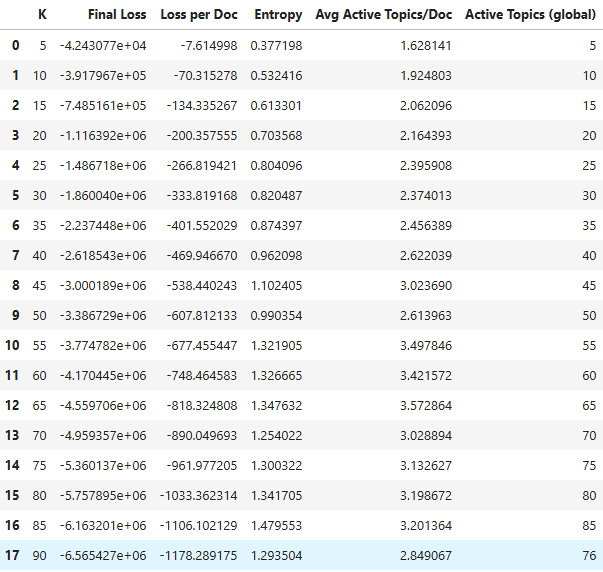

Why did we choose 60? ...

Introduction to Gensim and confirmation of our theory

In [ ]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, start=5, limit=90, step=1):
    coherence_values = []
    models_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha="auto",
        )
        models_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherencemodel.get_coherence())
    return models_list, coherence_values


# Compute
model_list, coherence_values = compute_coherence_values(
    dictionary, corpus, texts, start=5, limit=90, step=1
)

# Plot
x = range(5, 90)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("LDA Topic Coherence")
plt.grid()
plt.show()

### 3.2 Training the LDA Model with the selected K

Training properly and saving the results of the K=60 in a doc

In [ ]:
# Data loading
# X_array = np.load("/kaggle/input/bow-xarray/BoW_X_Array.npz")["arr_0"] # Uncomment this line if using Kaggle
X_array = np.load("BoW_X_Array.npz")["arr_0"]
X_tensor = torch.tensor(X_array, dtype=torch.float)

device = "cuda" if torch.cuda.is_available() else "cpu"
X_tensor = X_tensor.to(device)

num_docs, vocab_size = X_tensor.shape
K = 60

print(f"\n🚀 Training final LDA with K = {K} and 1000 steps...")


def lda_model(data):
    with pyro.plate("topics", K):
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(torch.ones(vocab_size).to(device))
        )
    with pyro.plate("documents", num_docs):
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(torch.ones(K).to(device)))
        logits = torch.matmul(doc_topics, topic_words).log()
        pyro.sample(
            "doc_words", dist.Multinomial(total_count=100, logits=logits), obs=data
        )


pyro.clear_param_store()
guide = AutoDelta(lda_model)
svi = SVI(lda_model, guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

# Training
num_steps = 1000
for step in range(num_steps):
    loss = svi.step(X_tensor)
    if step % 100 == 0:
        print(f"[step {step}] loss = {loss:.2f}")

# Extract posterior distributions
posterior = guide()
doc_topics = posterior["doc_topics"].detach().cpu().numpy()

# Save topic proportions for each document
doc_topics_df = pd.DataFrame(doc_topics, columns=[f"topic_{i}" for i in range(K)])
doc_topics_df.to_csv("doc_topics_K60.csv", index=False)
print("✅ doc_topics saved in 'doc_topics_K60.csv'")

### 3.3 Analysis of results

Little data analysis about the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the topic proportions matrix
doc_topics = pd.read_csv("doc_topics_K60.csv")  # or full path if needed
topic_matrix = doc_topics.values  # shape: [n_documents, K]

# 1. Average number of strong topics per document (threshold > 0.05)
strong_topic_counts = (topic_matrix > 0.05).sum(axis=1)
avg_strong_topics = np.mean(strong_topic_counts)
print(f"✅ Average strong topics per doc (>0.05): {avg_strong_topics:.2f}")

# 2. Total topic usage across all documents
topic_usage = topic_matrix.sum(axis=0)
most_used_topics = topic_usage.argsort()[::-1]
sorted_usage = topic_usage[most_used_topics]

# 3. Bar plot: Total usage per topic
plt.figure(figsize=(10, 5))
plt.bar(range(len(sorted_usage)), sorted_usage)
plt.xlabel("Topic Index (sorted)")
plt.ylabel("Total Usage Across Documents")
plt.title("Topic Usage Distribution (LDA K=60)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Summary printout
print(f"Most used topic index: {most_used_topics[0]} (weight = {sorted_usage[0]:.2f})")
print(
    f"Least used topic index: {most_used_topics[-1]} (weight = {sorted_usage[-1]:.2f})"
)

## 4. Bayesian Logistic Regression Classifier

In [ ]:
import pandas as pd
import numpy as np

import torch
from sklearn.model_selection import train_test_split

import pyro
import pyro.distributions as dist
import pyro.infer
from pyro.infer import MCMC, NUTS

In this section, the input to the Bayesian logistic regression classifier consists of two types of features: the bag-of-words (BoW) matrix and the topic distributions previously extracted using LDA. The BoW representation captures raw word frequency patterns across messages, while the topic vectors provide a semantic view of each message's content. Combining these two sources of information allows the model to leverage both surface-level and high-level patterns in the text.

Each SMS message is represented as a fixed-length feature vector that encodes both specific word counts and the proportions of latent topics it covers. This enriched input is used to train a Bayesian logistic regression model, where Gaussian priors are placed over the weights and bias. This Bayesian approach allows for modeling predictive uncertainty, which is particularly valuable in ambiguous cases where the model should express a lack of confidence. The following code defines the model, guide, and inference procedure using Pyro.

In [ ]:
df_k60 = pd.read_csv("doc_topics_K60.csv")

df_sms = pd.read_csv(
    "SMSSpamCollection", sep="\t", header=None, names=["label", "message"]
)
# df_sms.head()
df_sms["label"] = df_sms["label"].map({"ham": 0, "spam": 1})
df_sms.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df_k60["label"] = df_sms["label"]
df_k60.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_51,topic_52,topic_53,topic_54,topic_55,topic_56,topic_57,topic_58,topic_59,label
0,0.633960,0.000396,0.000135,0.000234,0.000026,0.070817,0.000136,0.000053,0.000028,0.070569,...,0.000231,0.000027,0.000078,0.000137,0.000230,0.000027,0.000066,0.000137,0.000230,0
1,0.002062,0.000005,0.000002,0.000008,0.000034,0.000018,0.000002,0.000007,0.000034,0.000011,...,0.000007,0.000128,0.001774,0.000002,0.000007,0.000141,0.199437,0.000002,0.000007,0
2,0.000004,0.000008,0.000002,0.000053,0.000004,0.000019,0.000002,0.000921,0.000004,0.000019,...,0.000748,0.000004,0.000019,0.000002,0.000734,0.000004,0.000019,0.000002,0.000776,1
3,0.007415,0.000008,0.000003,0.000013,0.000008,0.000130,0.000003,0.000012,0.000012,0.000138,...,0.000012,0.000008,0.000192,0.000003,0.000012,0.000008,0.000192,0.000003,0.000012,0
4,0.000024,0.007459,0.000013,0.000019,0.003461,0.000223,0.000013,0.000017,0.000089,0.133078,...,0.000018,0.000193,0.000223,0.000013,0.000018,0.000194,0.000223,0.000013,0.000018,0


In [ ]:
bow_array = np.load("BoW_X_Array.npz")["arr_0"]
bow_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### 4.1 Feature Preparation

Before defining the model, the input features for classification need to be constructed. The topic distributions previously computed using LDA and the bag-of-words matrix are concatenated to form a unified feature matrix. This combination captures both semantic (topics) and lexical (word frequency) information from the messages.

In [ ]:
X_topics = df_k60.drop("label", axis=1).values.astype("float32")

# Check shapes
print("Topics shape:", X_topics.shape)
print("BoW shape:", bow_array.shape)

X = np.hstack([X_topics, bow_array])
print("total shape: ", X.shape)

# labels
y = df_k60["label"].values.astype("float32")
print("labels shape", y.shape)

Topics shape: (5572, 60)
BoW shape: (5572, 7099)
total shape:  (5572, 7159)
labels shape (5572,)


After building the full feature matrix and label vector, the data is split into training and test sets to enable model evaluation. The split is stratified to maintain the original class distribution (spam vs. ham). Finally, the NumPy arrays are converted into PyTorch tensors, which are required by the Pyro modeling and inference functions.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# convert to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

### 4.2 Model Specification

The classifier is a Bayesian logistic regression model, where the input is a vector of features combining:
- Bag-of-words counts: capturing word-level frequency information.
- Topic proportions from LDA: capturing higher-level semantic structure.

Each feature has an associated weight and there's also a bias term. Both the weights and bias are treated as random variables with Gaussian priors. The model outputs the probability that a message is spam using a sigmoid function, and the target label is sampled from a Bernoulli distribution based on that probability. This setup allows us to infer a full posterior over the model parameters and capture uncertainty in the predictions.


In [ ]:
def model(X, y=None):
    num_features = X.shape[1]

    # Priors for weights and bias
    beta = pyro.sample(
        "beta", dist.Normal(torch.zeros(num_features), torch.ones(num_features))
    )
    bias = pyro.sample("bias", dist.Normal(0.0, 1.0))

    with pyro.plate("data", X.shape[0]):
        logits = (X @ beta) + bias
        pyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

### 4.3 Posterior inference with MCMC

After defining the model and preparing the data, inference is performed using Markov Chain Monte Carlo (MCMC), specifically the NUTS sampler provided by Pyro. NUTS is a variant of Hamiltonian Monte Carlo that adaptively tunes the sampling path length, making it efficient for high-dimensional posterior distributions. Here, MCMC is used to draw samples from the posterior distributions of the model’s weights and bias.

**need some bullshit for target_accept_prob value i put 0.75 to make it more aggressive**

In [ ]:
# MCMC inference
nuts_kernel = NUTS(model, target_accept_prob=0.75)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train, y_train)

Sample: 100%|██████████| 1100/1100 [06:29,  2.82it/s, step size=1.66e-01, acc. prob=0.810]


After sampling, the posterior mean of the weights (beta_hat) and bias (bias_hat) is computed and used to make predictions on the test set. The predicted probabilities are passed through a sigmoid function and thresholded at 0.5 to obtain binary predictions.

In [ ]:
# prediction using posterior mean
samples = mcmc.get_samples()
beta_hat = samples["beta"].mean(0)
bias_hat = samples["bias"].mean(0)

# Predict on test
logits = (X_test @ beta_hat) + bias_hat
y_pred = torch.sigmoid(logits) > 0.5

# Accuracy
accuracy = (y_pred.int() == y_test).float().mean()
print("Test Accuracy:", accuracy.item())

Test Accuracy: 0.9838564991950989


**some comments about the test accuracy, maybe also adding some other metrics**

To assess the quality of the posterior samples obtained from MCMC, diagnostic statistics can be printed using the following code. These include metrics such as the effective sample size (n_eff), the R̂ (r_hat) convergence diagnostic for each parameter, and any divergences or sampling issues during inference.

In [ ]:
print(mcmc.diagnostics())

{'beta': OrderedDict([('n_eff', tensor([1842.0730, 1314.8811, 1902.8448,  ..., 2543.2454, 1951.0995,
        2270.1492])), ('r_hat', tensor([0.9992, 0.9992, 0.9991,  ..., 0.9992, 0.9993, 0.9991]))]), 'bias': OrderedDict([('n_eff', tensor(1014.4557)), ('r_hat', tensor(1.0012))]), 'divergences': {'chain 0': []}, 'acceptance rate': {'chain 0': 1.0}}


**here some info about the diagnosis of the mcmc, didn't put anything because i'm waiting for the final results of the LDA**

## 5. Conclusions 